## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import time

from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, LRScheduler
from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV

import torch
import torch.nn as nn
import torch.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

In [5]:
# --- Device Configuration ---
# This determines if CUDA is available and sets the device accordingly.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device) # This sets the default device for new tensor creation
print(f"Using device: {device}")

Using device: cpu


In [4]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"CUDA is available. Number of GPUs found: {num_gpus}")

    # Print information for each GPU
    for i in range(num_gpus):
        print(f"\n--- GPU {i} ---")
        print(f"  Device Name: {torch.cuda.get_device_name(i)}")
        # Get memory information (total and currently used)
        total_memory_gb = torch.cuda.get_device_properties(i).total_memory / 1024**3
        print(f"  Total Memory: {total_memory_gb:.2f} GB")
        
        # This will show memory currently allocated by PyTorch,
        # but not necessarily all memory reserved by the driver.
        # It's useful for checking after a training run.
        allocated_memory_mb = torch.cuda.memory_allocated(i) / 1024**2
        cached_memory_mb = torch.cuda.memory_reserved(i) / 1024**2
        print(f"  Allocated Memory: {allocated_memory_mb:.2f} MB")
        print(f"  Cached Memory: {cached_memory_mb:.2f} MB")
        
else:
    print("CUDA is not available.")
    

##########################################################################

import os
import multiprocessing

# Get the number of CPU cores
num_cpu_cores = os.cpu_count()
# or
# num_cpu_cores = multiprocessing.cpu_count()

print('\n---Parallel computing unit count---')
print(f"n_jobs=-1 is equivalent to n_jobs = {num_cpu_cores}")

CUDA is not available.

---Parallel computing unit count---
n_jobs=-1 is equivalent to n_jobs = 12


## Dataset

In [6]:
def x_1_t(x_sequence: torch.Tensor) -> torch.Tensor:
    """
    Generates a synthetic time series x_1(t) using a non-diverging recursive function.

    This function defines x_1(t) based on its own past values (up to t-35)
    and past/present values of the input sequence x(t) (up to t-50).
    The coefficients are carefully chosen to ensure complexity without divergence.

    Args:
        x_sequence (torch.Tensor): A 1D tensor representing the input sequence x(t).
                                   Must have a length sufficient to cover all lags
                                   (i.e., at least 51 elements, as the loop starts at index 51).

    Returns:
        torch.Tensor: A 1D tensor representing the generated output sequence x_1(t).
    """
    # Set a specific seed for reproducibility of random initialization
    torch.manual_seed(21)
    # Initialize x_1 with small random noise. Its size matches the input x_sequence.
    x_1 = torch.randn(x_sequence.shape[0], dtype=torch.float32) * 0.1

    # --- Coefficients for the non-diverging recursive function for x_1 ---
    # These coefficients balance the influence of past x_1 and x values
    # and different non-linear behaviors (tanh, sin, sigmoid, exp, cos).
    C1 = 0.8    # Overall scale for tanh term, influencing recent x_1 values
    w_x1_1 = 0.5 # Weight for x_1(t-1) in tanh
    w_x1_2 = 0.3 # Weight for x_1(t-35) in tanh

    C2 = 0.7    # Overall scale for sine term, introducing periodicity driven by x
    w_x1 = 0.05 # Weight for x(t) in sine argument
    w_x2 = 0.03 # Weight for x(t-21) in sine argument

    C3 = 0.6    # Overall scale for sigmoid term, providing another bounded non-linearity
    w_x1_3 = 0.4 # Weight for x_1(t-42) in sigmoid
    w_x3 = 0.2  # Weight for x(t-50) in sigmoid

    C4 = 0.5    # Overall scale for exponential damping term
                # This term actively pulls x_1 towards 0 if x_1(t-28) becomes large,
                # contributing to non-divergence.

    C5 = 0.9    # Overall scale for cosine term, adding more periodicity from distant x_1 and x
    w_x1_4 = 0.02 # Weight for x_1(t-11) in cosine argument
    w_x4 = 0.01 # Weight for x(t-12) in cosine argument

    # The loop starts from an index that ensures all required past values (lags) are available.
    # The maximum lag used is 50 (from x[i-50]).
    # Therefore, 'i' must be at least 50. Starting at 51 ensures i-50 is at least 1.
    for i in range(51, len(x_sequence)):
        # Term 1: C1 * tanh(w_x1_1 * x_1(t-1) + w_x1_2 * x_1(t-35))
        term1 = C1 * torch.tanh(w_x1_1 * x_1[i-1] + w_x1_2 * x_1[i-35])

        # Term 2: C2 * sin(w_x1 * x(t) + w_x2 * x(t-21))
        term2 = C2 * torch.sin(w_x1 * x_sequence[i] + w_x2 * x_sequence[i-21])

        # Term 3: C3 * sigmoid(w_x1_3 * x_1(t-42) + w_x3 * x(t-50))
        term3 = C3 * torch.sigmoid(w_x1_3 * x_1[i-42] + w_x3 * x_sequence[i-50])

        # Term 4: C4 * exp(-abs(x_1(t-28))) - The damping term
        term4 = C4 * torch.exp(-torch.abs(x_1[i-28]))

        # Term 5: C5 * cos(w_x1_4 * x_1(t-11) + w_x4 * x(t-12))
        term5 = C5 * torch.cos(w_x1_4 * x_1[i-11] + w_x4 * x_sequence[i-12])

        # Sum all terms to get the current x_1(t) value
        x_1_current = term1 + term2 + term3 + term4 + term5
        x_1[i] = x_1_current

    return x_1

def x_2_t(x_sequence: torch.Tensor, x_1_sequence: torch.Tensor) -> torch.Tensor:
    """
    Generates a synthetic time series x_2(t) as a dynamical function of x(t) and x_1(t).

    This function defines x_2(t) based on its own past values (up to t-99),
    past values of x_1(t) (up to t-71), and past values of x(t) (up to t-45).
    The coefficients are distinct from x_1_t to ensure a different dynamic.

    Args:
        x_sequence (torch.Tensor): The base time index tensor (input sequence x(t)).
        x_1_sequence (torch.Tensor): The previously generated x_1(t) sequence.
                                     Must have the same length as x_sequence.

    Returns:
        torch.Tensor: The generated sequence x_2(t).
    """
    # Set a specific seed for reproducibility
    torch.manual_seed(42)
    # Initialize x_2 with small random noise, matching the length of input sequences.
    x_2 = torch.randn(x_sequence.shape[0], dtype=torch.float32) * 0.1

    # --- Coefficients for non-diverging recursive function for x_2 ---
    C1 = 0.7
    w_x2_1 = 0.5
    w_x2_2 = 0.3

    C2 = 0.6
    w_x1_1 = 0.05
    w_x_1 = 0.02

    C3 = 0.5
    w_x2_3 = 0.4
    w_x1_2 = 0.2

    C4 = 0.4

    C5 = 0.8
    w_x2_4 = 0.02
    w_x1_3 = 0.01

    # The loop starts from an index that ensures all required past values are available.
    # The maximum lag for x_2 is 99 (from x_2[i-99]).
    # Therefore, 'i' must be at least 99. Starting at 100 ensures i-99 is at least 1.
    for i in range(100, len(x_sequence)):
        # Term 1: C1 * tanh(w_x2_1 * x_2(t-99) + w_x2_2 * x_2(t-91))
        term1 = C1 * torch.tanh(w_x2_1 * x_2[i-99] + w_x2_2 * x_2[i-91])

        # Term 2: C2 * sin(w_x1_1 * x_1(t-23) + w_x_1 * x(t-45))
        term2 = C2 * torch.sin(w_x1_1 * x_1_sequence[i-23] + w_x_1 * x_sequence[i-45])

        # Term 3: C3 * sigmoid(w_x2_3 * x_2(t-78) + w_x1_2 * x_1(t-26))
        term3 = C3 * torch.sigmoid(w_x2_3 * x_2[i-78] + w_x1_2 * x_1_sequence[i-26])

        # Term 4: C4 * exp(-abs(x_2(t-17))) - The damping term
        term4 = C4 * torch.exp(-torch.abs(x_2[i-17]))

        # Term 5: C5 * cos(w_x2_4 * x_2(t-56) + w_x1_3 * x_1(t-71))
        term5 = C5 * torch.cos(w_x2_4 * x_2[i-56] + w_x1_3 * x_1_sequence[i-71])

        # Combine all terms to get the current x_2(t) value
        x_2_current = term1 + term2 + term3 + term4 + term5
        x_2[i] = x_2_current

    return x_2

def y_t(x_1_sequence: torch.Tensor, x_2_sequence: torch.Tensor) -> torch.Tensor:
    """
    Generates a synthetic time series y(t) using a non-diverging recursive function.

    This function defines y(t) based on its own past values (up to t-111),
    past values of x_1(t) (up to t-99), and past values of x_2(t) (up to t-82).

    Args:
        x_1_sequence (torch.Tensor): The sequence x_1(t).
        x_2_sequence (torch.Tensor): The sequence x_2(t).
                                     Both x_1 and x_2 must have sufficient length for lags.

    Returns:
        torch.Tensor: The generated sequence y(t).
    """
    # Set a specific seed for reproducibility
    torch.manual_seed(99)
    # Initialize y with small random noise. Its size matches the input sequences.
    y = torch.randn(x_1_sequence.shape[0], dtype=torch.float32) * 0.1

    # --- Coefficients for the recursive system for y ---
    C1 = 0.7
    w_y_1 = 0.5
    w_y_2 = 0.3

    C2 = 0.6
    w_x1 = 0.04
    w_x2 = 0.02

    C3 = 0.5
    w_y_3 = 0.4
    w_x1_2 = 0.2

    C4 = 0.4

    C5 = 0.8
    w_y_4 = 0.02
    w_x2_2 = 0.01

    # The loop starts from an index that ensures all required past values are available.
    # The maximum lag for y is 111 (from y[i-111]).
    # Therefore, 'i' must be at least 111. The current loop starts at 150, which is safe.
    for i in range(150, len(x_1_sequence)):
        # Term 1: C1 * tanh(w_y_1 * y(t-20) + w_y_2 * y(t-111))
        term1 = C1 * torch.tanh(w_y_1 * y[i-20] + w_y_2 * y[i-111])

        # Term 2: C2 * sin(w_x1 * x_1(t-30) + w_x2 * x_2(t-38))
        term2 = C2 * torch.sin(w_x1 * x_1_sequence[i-30] + w_x2 * x_2_sequence[i-38])

        # Term 3: C3 * sigmoid(w_y_3 * y(t-102) + w_x1_2 * x_1(t-99))
        term3 = C3 * torch.sigmoid(w_y_3 * y[i-102] + w_x1_2 * x_1_sequence[i-99])

        # Term 4: C4 * exp(-abs(y(t-4))) - The damping term
        term4 = C4 * torch.exp(-torch.abs(y[i-4]))

        # Term 5: C5 * cos(w_y_4 * y(t-5) + w_x2_2 * x_2(t-82))
        term5 = C5 * torch.cos(w_y_4 * y[i-5] + w_x2_2 * x_2_sequence[i-82])

        # Combine all terms to get the current y(t) value
        y_current = term1 + term2 + term3 + term4 + term5
        y[i] = y_current

    return y

# Define parameters for the time series generation
DateTime_init = pd.to_datetime('2022-01-01') # Start date for the time series
DateTime_step = pd.Timedelta('1d')          # Step size for each time point (1 day)
Number_step = 1200                           # Total number of time steps (data points)

# Generate time indices: a simple linear sequence for x_seq and a datetime range
x_seq = torch.arange(0, Number_step, 1, dtype=torch.float32) # Input sequence for the recursive functions
DateTime = pd.date_range(start=DateTime_init, periods=Number_step, freq=DateTime_step)

# Generate the synthetic time series using the defined functions
# Note: The functions are designed to generate non-diverging series.
# The random noise (0 * torch.randn) is currently set to zero, meaning no additional
# independent noise is added beyond the initial small random values.

# We are predicting y which is a function of x_1 and x_2.
x_1 = 25 * x_1_t(x_seq) + 0 * torch.randn(x_seq.shape, dtype=torch.float32)
x_2 = 20 * x_2_t(x_seq, x_1) + 0 * torch.randn(x_seq.shape, dtype=torch.float32)
y = 15 * y_t(x_1, x_2) + 0 * torch.randn(x_seq.shape, dtype=torch.float32)

# Make Train, Validation and Test target (y)
torch.manual_seed(21)
y_train = y + 1 * torch.randn(y.shape)
y_val = y + 1 * torch.randn(y.shape)
y_test = y + 1 * torch.randn(y.shape)

# Create a Pandas DataFrame to store the generated time series
df = pd.DataFrame(
    {
        'DateTime': DateTime,
        'x_1': x_1.cpu().numpy(), # Convert PyTorch tensor to NumPy array for Pandas
        'x_2': x_2.cpu().numpy(),
        'y': y.cpu().numpy(),
        'y_train': y_train.cpu().numpy(),
        'y_val': y_val.cpu().numpy(),
        'y_test': y_test.cpu().numpy(),
    }
)

# Filter the DataFrame to start from a specific date
df = df[df['DateTime'] >= pd.to_datetime('2022-09-01')]
# Set the 'DateTime' column as the DataFrame index
df = df.set_index('DateTime')

# Scale data 
scaler_x_1 = StandardScaler()
scaler_x_2 = StandardScaler()
scaler_y = StandardScaler()

x_1_scaled = scaler_x_1.fit_transform(df['x_1'].to_numpy().reshape(-1, 1))
x_2_scaled = scaler_x_2.fit_transform(df['x_2'].to_numpy().reshape(-1, 1))
y_scaled = scaler_y.fit_transform(df['y'].to_numpy().reshape(-1, 1))

y_train_scaled = scaler_y.transform(df['y_train'].to_numpy().reshape(-1, 1))
y_val_scaled = scaler_y.transform(df['y_val'].to_numpy().reshape(-1, 1))
y_test_scaled = scaler_y.transform(df['y_test'].to_numpy().reshape(-1, 1))

df['x_1_scaled'] = x_1_scaled
df['x_2_scaled'] = x_2_scaled
df['y_scaled'] = y_scaled
df['y_train_scaled'] = y_train_scaled
df['y_val_scaled'] = y_val_scaled
df['y_test_scaled'] = y_test_scaled

model_loss = dict()

In [8]:
# --- Visualization using Plotly  ---
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

columns = ['y', 'y_train', 'y_val', 'y_test']
columns_name = ['y', 'y_train', 'y_val', 'y_test']

for i in range(len(columns)):
    fig.add_trace(go.Scatter(x=df.index, y=df[columns[i]], mode='lines', name=columns_name[i]))

fig.update_layout(
    title='Generated Synthetic Time Series x_1(t), x_2(t), and y(t)',
    xaxis_title='DateTime',
    yaxis_title='Value',
    legend_title='Series',
    hovermode="x unified"
)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey')

fig.show()

### Data Preparation

In [9]:
##### Data Preparation

def to_sequence_timestep(lag: int, df: pd.DataFrame, input_cols: list, target_cols: list):
    input_values = df[input_cols].values
    target_values = df[target_cols].values
    x_seq = []
    y_seq = []

    for i in range(len(df) - lag):
        x_seq.append(input_values[i:i+lag, :])
        y_seq.append(target_values[i+lag, :])

    # To avoid the warning of slow executing time, convert into np.array first
    x_seq = np.array(x_seq)
    y_seq = np.array(y_seq)

    x_seq = torch.tensor(x_seq, dtype=torch.float32).view(-1, lag, len(input_cols))
    y_seq = torch.tensor(y_seq, dtype=torch.float32).view(-1, len(target_cols))

    return x_seq, y_seq

##### Make Input Sequences #####
lag = 120

# Create sequences
x_train_scaled, y_train_scaled = to_sequence_timestep(
    lag = lag, 
    df = df,
    input_cols = ['x_1_scaled', 'x_2_scaled', 'y_train_scaled'], 
    target_cols = ['y_train_scaled'], 
)
x_train_scaled = x_train_scaled.to(device)
y_train_scaled = y_train_scaled.to(device)

x_val_scaled, y_val_scaled = to_sequence_timestep(
    lag = lag, 
    df = df,
    input_cols = ['x_1_scaled', 'x_2_scaled', 'y_val_scaled'], 
    target_cols = ['y_val_scaled'], 
)
x_val_scaled = x_val_scaled.to(device)
y_val_scaled = y_val_scaled.to(device)

x_test_scaled, y_test_scaled = to_sequence_timestep(
    lag = lag, 
    df = df,
    input_cols = ['x_1_scaled', 'x_2_scaled', 'y_test_scaled'], 
    target_cols = ['y_test_scaled'], 
)
x_test_scaled = x_test_scaled.to(device)
y_test_scaled = y_test_scaled.to(device)

# Make DataLoaders
train_dataset = TensorDataset(x_train_scaled, y_train_scaled)
val_dataset = TensorDataset(x_val_scaled, y_val_scaled)
test_dataset = TensorDataset(x_test_scaled, y_test_scaled)

# The issue is from shuffling mechanics of torch making data in train_dataloader locates in cpu instead of gpu which we don't want to, so we apply generator manually.
# Create a generator for reproducibility and device consistency
g = torch.Generator(device=device)
g.manual_seed(0) # You can set a seed for reproducibility of shuffling

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True, generator = g)
val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

# Store scalers for later denormalization
# To denormalize: scaler_y.inverse_transform(predictions.detach().numpy())

## LSTM models

In [11]:
class LSTM(nn.Module):
    def __init__(self, 
                 input_size: int = 1, 
                 output_size: int = 1, 
                 hidden_size: int = 64, 
                 num_layers: int = 2, 
                 dropout: float = 0.1, 
                 batch_first: bool = True,
                 ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=batch_first
        )

        # self.fc = nn.Linear(hidden_size, output_size)

        # --- Regression Head ---
        # A series of linear layers to map the LSTM's output to the final prediction
        self.regression_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        out = self.regression_head(lstm_out[:, -1, :])  # Use the last time step
        return out

## Transformer models

From [Attention is all we need](https://arxiv.org/abs/1706.03762v7), transformer can fall into 3 types base on their components:

1. Encoder only Transformer
2. Decoder only Transformer
3. Encoder-Decoder Transformer

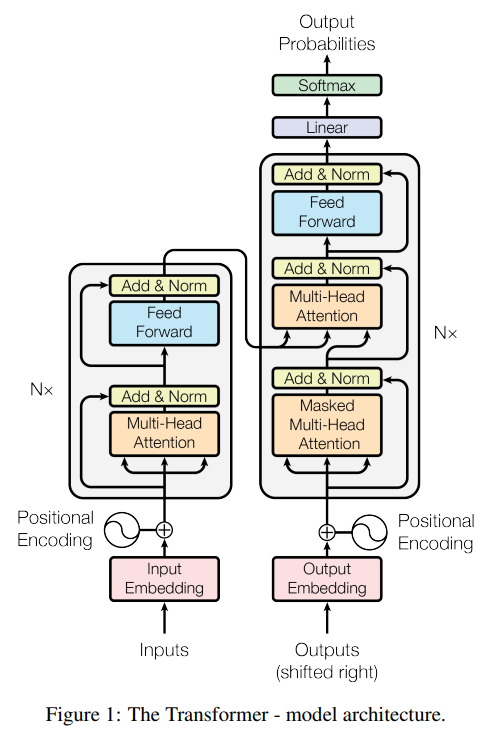

#### Positional Encoding

The positional encoding is used to give the model information about the position of each token in the sequence. It is defined as:
$$\text{PE}_{(\text{pos}, 2i)} = \sin\left(\frac{\text{pos}}{10000^{2i/d_\text{model}}}\right)$$
$$\text{PE}_{(\text{pos}, 2i+1)} = \cos\left(\frac{\text{pos}}{10000^{2i/d_\text{model}}}\right)$$
where $\text{pos}$ is the position of the token in the sequence, $i$ is the dimension index, and $d_\text{model}$ is the dimensionality of the model.

Practically, the ``div_term`` is derived into the form:
$$\mathrm{div\_term} = \exp\left(\frac{i (-\log 10000)}{d_\mathrm{model}}\right).$$



In [12]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # d_model must be even
        d_model_even = 2 * ((d_model + 1) // 2)

        pe = torch.zeros(max_len, d_model_even)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe[:, :d_model]
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        
        x = x + self.pe[:, :x.size(1), :]  # Ensure correct slicing

        return self.dropout(x)          # avoid overfitting with dropout regularization

#### Encoder only Transformer

In [13]:
class TransformerEncoderModel(nn.Module):
    """
    A Transformer Encoder model for sequence-to-one regression tasks.
    """
    def __init__(self,
                 input_dim: int = 1,
                 output_dim: int = 1,
                 seq_len: int = 200,
                 d_model: int = 16,
                 nhead: int = 4,
                 num_layers: int = 2,
                 dim_feedforward: int = 64,
                 dropout: float = 0.1,
                 ):
        super().__init__()

        self.seq_len = seq_len
        self.d_model = d_model

        # --- Embedding and Positional Encoding ---
        # Linear layer to embed the input dimension into the model's dimension
        self.input_embedding  = nn.Linear(input_dim, d_model)
        # Adds positional information to the embedded sequence
        self.position_encoder = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=seq_len)

        # --- Transformer Encoder ---
        # Define a single encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Crucial for (batch, seq_len, feature) shape
        )
        # Stack multiple encoder layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # --- Regression Head ---
        # A series of linear layers to map the transformer's output to the final prediction
        self.regression_head = nn.Sequential(
            nn.Linear(seq_len * d_model, d_model * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, output_dim)
        )

    # Model Forward Pass
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor, shape [batch_size, seq_len, input_dim]
        """
        # 1. Embed the input and add positional encoding
        x = self.input_embedding(x)
        x = self.position_encoder(x)

        # 2. Pass through the transformer encoder
        x = self.transformer_encoder(x)

        # 3. Flatten the output for the regression head
        x = x.reshape(-1, self.seq_len * self.d_model)

        # 4. Pass through the regression head
        x = self.regression_head(x)

        return x

#### Decoder only Transformer

In [14]:
# --- Decoder-Only Transformer Model ---
class TransformerDecoderModel(nn.Module):
    """
    A Decoder-Only Transformer model for sequence-to-one regression tasks.
    """
    def __init__(self,
                 input_dim: int = 1,
                 output_dim: int = 1,
                 seq_len: int = 200,
                 d_model: int = 16,
                 nhead: int = 4,
                 num_layers: int = 2,
                 dim_feedforward: int = 64,
                 dropout: int = 0.1,
                 ):
        super().__init__()

        self.seq_len = seq_len
        self.d_model = d_model

        # --- Embedding and Positional Encoding ---
        # Linear layer to embed the input dimension into the model's dimension
        self.input_embedding  = nn.Linear(input_dim, d_model)
        # Adds positional information to the embedded sequence
        self.position_encoder = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=seq_len)

        # --- Transformer Decoder ---
        # Define a single decoder layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Crucial for (batch, seq_len, feature) shape
        )
        # Stack multiple decoder layers
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # --- Regression Head ---
        # A series of linear layers to map the transformer's output to the final prediction
        self.regression_head = nn.Sequential(
            nn.Linear(seq_len * d_model, d_model * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, output_dim)
        )

    def _generate_causal_mask(self, sz: int) -> torch.Tensor:
        """
        Generates a square causal mask for the sequence.
        The masked positions are filled with float('-inf').
        Unmasked positions are filled with float(0.0).
        This prevents the model from attending to future tokens.
        """
        return nn.Transformer.generate_square_subsequent_mask(sz)

    # Model Forward Pass
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor, shape [batch_size, seq_len, input_dim]
        """
        # 1. Generate the causal mask and move it to the correct device
        # The mask ensures that a position can only attend to itself and previous positions.
        causal_mask = self._generate_causal_mask(self.seq_len).to(x.device)

        # 2. Embed the input and add positional encoding
        x = self.input_embedding(x)
        x = self.position_encoder(x)

        # 3. Pass through the transformer decoder
        # For a decoder-only architecture, the target (tgt) and memory are the same.
        # We apply the causal mask to the target sequence attention.
        x = self.transformer_decoder(tgt=x, memory=x, tgt_mask=causal_mask)

        # 4. Flatten the output for the regression head
        x = x.reshape(-1, self.seq_len * self.d_model)

        # 5. Pass through the regression head
        x = self.regression_head(x)

        return x

#### Encoder-Decoder Transformer

In [15]:
# --- Encoder-Decoder Transformer Model ---
class TransformerEncoderDecoderModel(nn.Module):
    """
    A standard Encoder-Decoder Transformer model for sequence-to-sequence tasks.
    """
    def __init__(self,
                 input_dim: int = 1,
                 output_dim: int = 1,
                 seq_len: int = 200,
                 d_model: int = 16,
                 nhead: int = 4,
                 num_encoder_layers: int = 2,
                 num_decoder_layers: int = 2,
                 dim_feedforward: int = 64,
                 dropout: float = 0.1
                 ):
        super().__init__()

        self.seq_len = seq_len
        self.d_model = d_model

        self.output_dim = output_dim

        # --- Core Transformer ---
        # Using PyTorch's built-in nn.Transformer module which contains both encoder and decoder
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Ensures input/output shapes are (batch, seq, feature)
        )

        # --- Embedding and Positional Encoding ---
        # Linear layers to embed the source and target sequences into the model's dimension
        self.source_embedding = nn.Linear(input_dim, d_model)
        self.target_embedding = nn.Linear(output_dim, d_model) # Target input embedding

        # Adds positional information to the embedded sequences
        self.src_position_encoder = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=seq_len)
        self.tgt_position_encoder = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=1)

         # --- Regression Head ---
        # A series of linear layers to map the transformer's output to the final prediction
        self.regression_head = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, output_dim)
        )

        # # --- Final Output Layer ---
        # # Maps the decoder's output from d_model to the desired output dimension
        # self.output_layer = nn.Linear(d_model, output_dim)

    def _generate_causal_mask(self, sz: int) -> torch.Tensor:
        """
        Generates a square causal mask for the sequence.
        This prevents the decoder from attending to future tokens during training.
        """
        return nn.Transformer.generate_square_subsequent_mask(sz)

    def forward(self, src: torch.Tensor, tgt: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            src: Source sequence, shape [batch_size, src_seq_len, input_dim]
            tgt: Target sequence, shape [batch_size, tgt_seq_ln, output_dim]
        """
        
        # --- FIXED LOGIC: Use a single variable for the decoder input ---
        if tgt is None:
            # Inference mode: use a placeholder as the decoder input
            batch_size = src.size(0)
            tgt_seq_input = torch.zeros(batch_size, 1, self.output_dim, device=src.device)
        else:
            # Training mode: use the teacher-forced target as the decoder input
            if tgt.dim() == 2:
                # Reshape target from [batch, output_dim] to [batch, 1, output_dim]
                tgt_seq_input = tgt.unsqueeze(1)
            else:
                # If it already has the sequence dimension, use it as is
                tgt_seq_input = tgt

        # 1. Generate masks
        # Use the sequence length of the *reshaped* decoder input
        tgt_seq_len = tgt_seq_input.size(1)
        tgt_mask = self._generate_causal_mask(tgt_seq_len).to(src.device)

        # 2. Embed source and target sequences and add positional encoding
        # Use the `tgt_seq_input` variable consistently
        src_embedded = self.src_position_encoder(self.source_embedding(src))
        tgt_embedded = self.tgt_position_encoder(self.target_embedding(tgt_seq_input))

        # print(f"src_embedded shape: {src_embedded.shape}, tgt_embedded shape: {tgt_embedded.shape}")
        
        # 3. Pass through the transformer
        x = self.transformer(
            src=src_embedded,
            tgt=tgt_embedded,
            tgt_mask=tgt_mask
        )

        # 4. Pass through the regression head
        x = self.regression_head(x[:, -1, :]) # Use only the last token's output for regression

        return x


## Experiment

#### Define Functions

In [ ]:
def trainer(model, optimizer, train_dataloader, criterion=nn.MSELoss(), 
            x_val_scaled=None, y_val_scaled=None, scheduler=None, 
            max_epochs=50, early_stopping_patience=-1):
    """
    Train a model with optional early stopping and validation loss tracking.
    """
    loss_history = []
    val_loss_history = []

    best_model_state = model.state_dict()
    min_val_loss = float('inf')
    early_stop_counter = 0

    print("\n--- Training Started ---")
    for epoch in range(max_epochs):
        model.train()
        epoch_loss = 0.0

        for xb, yb in train_dataloader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            y_pred = model(xb)
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_dataloader)
        loss_history.append(avg_train_loss)

        # --- Validation ---
        val_loss_value = float('nan')
        if x_val_scaled is not None and y_val_scaled is not None:
            model.eval()
            with torch.no_grad():
                x_val_scaled = x_val_scaled.to(device)
                y_val_scaled = y_val_scaled.to(device)
                y_val_pred = model(x_val_scaled)
                val_loss = criterion(y_val_pred, y_val_scaled)
                val_loss_value = val_loss.item()
                val_loss_history.append(val_loss_value)

            # Scheduler update
            if scheduler is not None:
                scheduler.step(val_loss_value)

            # Early stopping check
            if early_stopping_patience != -1:
                if val_loss_value < min_val_loss:
                    min_val_loss = val_loss_value
                    best_model_state = model.state_dict()
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1
                    if early_stop_counter >= early_stopping_patience:
                        print(f"Early stopping at epoch {epoch}")
                        break

        print(f"Epoch {epoch:3d} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {val_loss_value:.4f}")

    # Load best model
    model.load_state_dict(best_model_state)
    print("Training completed.")

    # ---- Plot loss curves and gradients ----
    plot_losses(loss_history, val_loss_history)

    return model, [loss_history, val_loss_history]

############################################################################################################################

def predictor(model, x_test_scaled, y_test_scaled, criterion=nn.MSELoss(), scaler_y=None):
    """
    Predict and optionally denormalize results using given model and test set.
    """
    model.eval()
    with torch.no_grad():
        x_test_scaled = x_test_scaled.to(device)
        y_pred_scaled = model(x_test_scaled)

    # Compute evaluation loss
    eval_loss = criterion(y_pred_scaled.cpu(), y_test_scaled.cpu())

    if scaler_y is not None:
        y_pred = scaler_y.inverse_transform(y_pred_scaled.cpu())
        return y_pred, eval_loss
    else:
        return y_pred_scaled, eval_loss

#############################################################################################################################

def plot_losses(loss_history, val_loss_history=None, gradient_plot=True):
    """
    Plot training/validation losses and optionally their gradients.
    """
    epochs = np.arange(len(loss_history))
    losses_grad = np.gradient(loss_history)
    val_losses_grad = np.gradient(val_loss_history) if val_loss_history else []

    if gradient_plot:
        fig, ax = plt.subplots(2, 1, figsize=(10, 8))

        ax[0].plot(loss_history, label='Training Loss', color='dodgerblue')
        if val_loss_history:
            ax[0].plot(val_loss_history, linestyle='--', color='orangered', label='Validation Loss')
        ax[0].set_title('Training and Validation Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()
        ax[0].grid(True)

        ax[1].plot(epochs, losses_grad, label='Training Loss Gradient', color='dodgerblue')
        if val_loss_history:
            ax[1].plot(epochs, val_losses_grad, linestyle='--', color='orangered', label='Validation Loss Gradient')
        ax[1].set_title('Gradient of Loss Curves')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Gradient')
        ax[1].legend()
        ax[1].grid(True)

    else:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(loss_history, label='Training Loss', color='dodgerblue')
        if val_loss_history:
            ax.plot(val_loss_history, linestyle='--', color='orangered', label='Validation Loss')
        ax.set_title('Training and Validation Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    return fig


### LSTM

#### Bayesian Optimization

In [129]:
net = NeuralNetRegressor(
    module=LSTM,
    module__input_size=3,
    module__output_size=1,
    module__dropout=0.1,
    max_epochs=200,            # You might want to increase this for better training
    lr=0.0001,                  # Initial learning rate, will be optimized
    batch_size = 32, 
    optimizer=Adam,
    criterion=nn.MSELoss,
    device=device,
    verbose=0,
    callbacks=[
        ('lr_scheduler', LRScheduler(
            policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
            monitor='valid_loss', # Monitor validation loss to trigger reduction
            factor=0.2,
            patience=3,
        )),
        ('early_stopping', EarlyStopping(
            monitor='valid_loss',    # Monitor validation loss
            patience=10,             # Number of epochs with no improvement before stopping
            threshold=1e-4,          # Minimum change in the monitored metric to qualify as an improvement
            threshold_mode='rel',    # Relative change (can also be 'abs' for absolute change)
            lower_is_better=True,    # Lower validation loss is better
            load_best=True           # Load the best model weights after stopping
        )),
    ]
)

search_spaces = {
    'module__hidden_size': Categorical([16, 32, 64, 128]),            
    'module__num_layers': Categorical([2, 3, 4, 5, 6]),  
}

opt = BayesSearchCV(
    estimator=net,
    search_spaces=search_spaces,
    n_iter=20,                          # Number of optimization iterations
    cv=3,                               # 3-fold cross-validation
    scoring='neg_mean_squared_error',   # Optimize for negative MSE (skopt minimizes)
    verbose=2,
    n_jobs=5,                          # Use 10 CPU cores (from 28) for parallelizing folds without making CUDA memory run out.
    random_state=42,
)

In [130]:
# Run the Bayesian Optimization

x_scaled_cpu = x_train_scaled.cpu().numpy()
y_scaled_cpu = y_train_scaled.cpu().numpy()

print("Starting Bayesian Optimization...")

# Clear CUDA cache before starting hyperparameter search
if torch.cuda.is_available():
    torch.cuda.empty_cache()

opt.fit(x_scaled_cpu, y_scaled_cpu) 

Starting Bayesian Optimization...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .......module__hidden_size=32, module__num_layers=5; total time=   0.5s
[CV] END .......module__hidden_size=32, module__num_layers=5; total time=   0.5s
[CV] END .......module__hidden_size=32, module__num_layers=5; total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ......module__hidden_size=128, module__num_layers=6; total time=   2.2s
[CV] END ......module__hidden_size=128, module__num_layers=6; total time=   2.2s
[CV] END ......module__hidden_size=128, module__num_layers=6; total time=   2.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .......module__hidden_size=32, module__num_layers=6; total time=   0.6s
[CV] END .......module__hidden_size=32, module__num_layers=6; total time=   0.6s
[CV] END .......module__hidden_size=32, module__num_layers=6; total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[

/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(128), np.int64(2)] before, using random point [128, 6]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ......module__hidden_size=128, module__num_layers=6; total time=   2.2s
[CV] END ......module__hidden_size=128, module__num_layers=6; total time=   2.2s
[CV] END ......module__hidden_size=128, module__num_layers=6; total time=   2.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ......module__hidden_size=128, module__num_layers=3; total time=   1.2s
[CV] END ......module__hidden_size=128, module__num_layers=3; total time=   2.0s
[CV] END ......module__hidden_size=128, module__num_layers=3; total time=   2.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .......module__hidden_size=16, module__num_layers=5; total time=   0.5s
[CV] END .......module__hidden_size=16, module__num_layers=5; total time=   0.5s
[CV] END .......module__hidden_size=16, module__num_layers=5; total time=   0.5s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(128), np.int64(2)] before, using random point [16, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .......module__hidden_size=16, module__num_layers=2; total time=   0.4s
[CV] END .......module__hidden_size=16, module__num_layers=2; total time=   4.3s
[CV] END .......module__hidden_size=16, module__num_layers=2; total time=   4.4s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(128), np.int64(2)] before, using random point [128, 5]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ......module__hidden_size=128, module__num_layers=5; total time=   1.8s
[CV] END ......module__hidden_size=128, module__num_layers=5; total time=   1.8s
[CV] END ......module__hidden_size=128, module__num_layers=5; total time=   1.9s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(128), np.int64(2)] before, using random point [32, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .......module__hidden_size=32, module__num_layers=2; total time=   0.4s
[CV] END .......module__hidden_size=32, module__num_layers=2; total time=   1.0s
[CV] END .......module__hidden_size=32, module__num_layers=2; total time=   3.2s


,estimator,"<class 'skorc...tput_size=1, )"
,search_spaces,"{'module__hidden_size': Categorical(c...), prior=None), 'module__num_layers': Categorical(c...), prior=None)}"
,optimizer_kwargs,None
,n_iter,20
,scoring,'neg_mean_squared_error'
,fit_params,None
,n_jobs,5
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [ ]:
# Print the results
print("\n Bayesian Search finished.")
print(f"Best parameters found: {opt.best_params_}")
print(f"Best cross-validation score (negative MSE): {opt.best_score_}")

best_params_model = opt.best_params_

torch.manual_seed(21)

model_LSTM_Bayesian = LSTM(
    input_size=3, 
    output_size=1, 
    hidden_size=best_params_model['module__hidden_size'], 
    num_layers=best_params_model['module__num_layers'], 
    dropout=0.1, 
    batch_first=True
)
optimizer = Adam(model_LSTM_Bayesian.parameters(), lr=0.0001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0
patience = 10
min_loss = float('inf')

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3)        # To adjust learning rates

print("\n--- Model ---")
print("Model architecture:")
print(model_LSTM_Bayesian)
print(f"Total parameters: {sum(p.numel() for p in model_LSTM_Bayesian.parameters() if p.requires_grad)}")



--- Model ---
Model architecture:
LSTM(
  (lstm): LSTM(3, 128, num_layers=2, batch_first=True, dropout=0.1)
  (regression_head): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
  )
)
Total parameters: 430593


#### Grid Search

In [ ]:
# Define the Skorch NeuralNetRegressor
# This wraps your PyTorch model to make it scikit-learn compatible

net = NeuralNetRegressor(
    module=LSTM,
    module__input_size=3,
    module__output_size=1,
    module__dropout=0.1,
    max_epochs=200,            # You might want to increase this for better training
    lr=0.0001,                  # Initial learning rate, will be optimized
    optimizer=Adam,
    criterion=nn.MSELoss,
    batch_size = 32, 
    device=device,
    verbose=0,
    callbacks=[
        ('lr_scheduler', LRScheduler(
            policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
            monitor='valid_loss', # Monitor validation loss to trigger reduction
            factor=0.2,
            patience=3,
        )),
        ('early_stopping', EarlyStopping(
            monitor='valid_loss',    # Monitor validation loss
            patience=10,             # Number of epochs with no improvement before stopping
            threshold=1e-4,          # Minimum change in the monitored metric to qualify as an improvement
            threshold_mode='rel',    # Relative change (can also be 'abs' for absolute change)
            lower_is_better=True,    # Lower validation loss is better
            load_best=True           # Load the best model weights after stopping
        )),
    ]
)

param_grid = {
    'module__hidden_size': [16, 32, 64, 128],            # Ensure divisibility (d_model % nhead == 0)
    'module__num_layers': [2, 3, 4, 5, 6],                    # Reduced max layers
}

opt = GridSearchCV(
    estimator=net,
    param_grid=param_grid,
    cv=3,                               # 3-fold cross-validation
    scoring='neg_mean_squared_error',   # Optimize for negative MSE (skopt minimizes)
    verbose=2, 
    n_jobs=5,                         # Use 9 CPU cores (from 29) for parallelizing folds without making CUDA memory run out.
)

# Run the Grid Search

x_scaled_cpu = x_test_scaled.cpu().numpy()
y_scaled_cpu = y_test_scaled.cpu().numpy()

print("Starting Grid Search")

# Clear CUDA cache before starting hyperparameter search
if torch.cuda.is_available():
    torch.cuda.empty_cache()

opt.fit(x_scaled_cpu, y_scaled_cpu) 

Starting Grid Search
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .......module__hidden_size=16, module__num_layers=2; total time=   1.3s
[CV] END .......module__hidden_size=16, module__num_layers=3; total time=   1.3s
[CV] END .......module__hidden_size=16, module__num_layers=4; total time=   1.5s
[CV] END .......module__hidden_size=16, module__num_layers=5; total time=   2.6s
[CV] END .......module__hidden_size=16, module__num_layers=5; total time=   1.6s
[CV] END .......module__hidden_size=16, module__num_layers=6; total time=   1.6s
[CV] END .......module__hidden_size=32, module__num_layers=2; total time=   1.5s
[CV] END .......module__hidden_size=16, module__num_layers=3; total time=   5.1s
[CV] END .......module__hidden_size=16, module__num_layers=6; total time=   3.4s
[CV] END .......module__hidden_size=16, module__num_layers=4; total time=   6.4s
[CV] END .......module__hidden_size=16, module__num_layers=5; total time=   5.0s
[CV] END .......module__hid

,estimator,"<class 'skorc...tput_size=1, )"
,param_grid,"{'module__hidden_size': [16, 32, ...], 'module__num_layers': [2, 3, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,10
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,module,<class '__main__.LSTM'>


In [ ]:
# Print the results
print("\n Grid Search finished.")
print(f"Best parameters found: {opt.best_params_}")
print(f"Best cross-validation score (negative MSE): {opt.best_score_}")

best_params_model = opt.best_params_

torch.manual_seed(21)
model_LSTM_Grid = LSTM(
    hidden_size = best_params_model['module__hidden_size'],
    num_layers = best_params_model['module__num_layers'],
    input_size=3,
)

optimizer = Adam(model_LSTM_Grid.parameters(), lr=0.0001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0
patience = 10
min_loss = float('inf')

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3)        # To adjust learning rates

print("\n--- Model ---")
print("Model architecture:")
print(model_LSTM_Grid)
print(f"Total parameters: {sum(p.numel() for p in model_LSTM_Grid.parameters() if p.requires_grad)}")




 Grid Search finished.
Best parameters found: {'module__hidden_size': 128, 'module__num_layers': 2}
Best cross-validation score (negative MSE): -0.14277969300746918

--- Model ---
Model architecture:
LSTM(
  (lstm): LSTM(3, 128, num_layers=2, batch_first=True, dropout=0.1)
  (regression_head): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
  )
)
Total parameters: 430593



--- Training ---
Training started...
Epoch 0 | Train Loss: 1.1332 | Validation (Test) Loss: 1.1116
Epoch 1 | Train Loss: 1.0113 | Validation (Test) Loss: 0.9868
Epoch 2 | Train Loss: 0.7540 | Validation (Test) Loss: 0.5073
Epoch 3 | Train Loss: 0.3973 | Validation (Test) Loss: 0.3112
Epoch 4 | Train Loss: 0.2596 | Validation (Test) Loss: 0.2164
Epoch 5 | Train Loss: 0.1977 | Validation (Test) Loss: 0.1578
Epoch 6 | Train Loss: 0.1510 | Validation (Test) Loss: 0.1235
Epoch 7 | Train Loss: 0.1375 | Validation (Test) Loss: 0.1129
Epoch 8 | Train Loss: 0.1459 | Validation (Test) Loss: 0.1151
Epoch 9 | Train Loss: 0.1334 | Validation (Test) Loss: 0.1101
Epoch 10 | Train Loss: 0.1347 | Validation (Test) Loss: 0.1127
Epoch 11 | Train Loss: 0.1328 | Validation (Test) Loss: 0.1084
Epoch 12 | Train Loss: 0.1271 | Validation (Test) Loss: 0.1143
Epoch 13 | Train Loss: 0.1318 | Validation (Test) Loss: 0.1119
Epoch 14 | Train Loss: 0.1255 | Validation (Test) Loss: 0.1082
Epoch 15 | Train Loss: 0.12

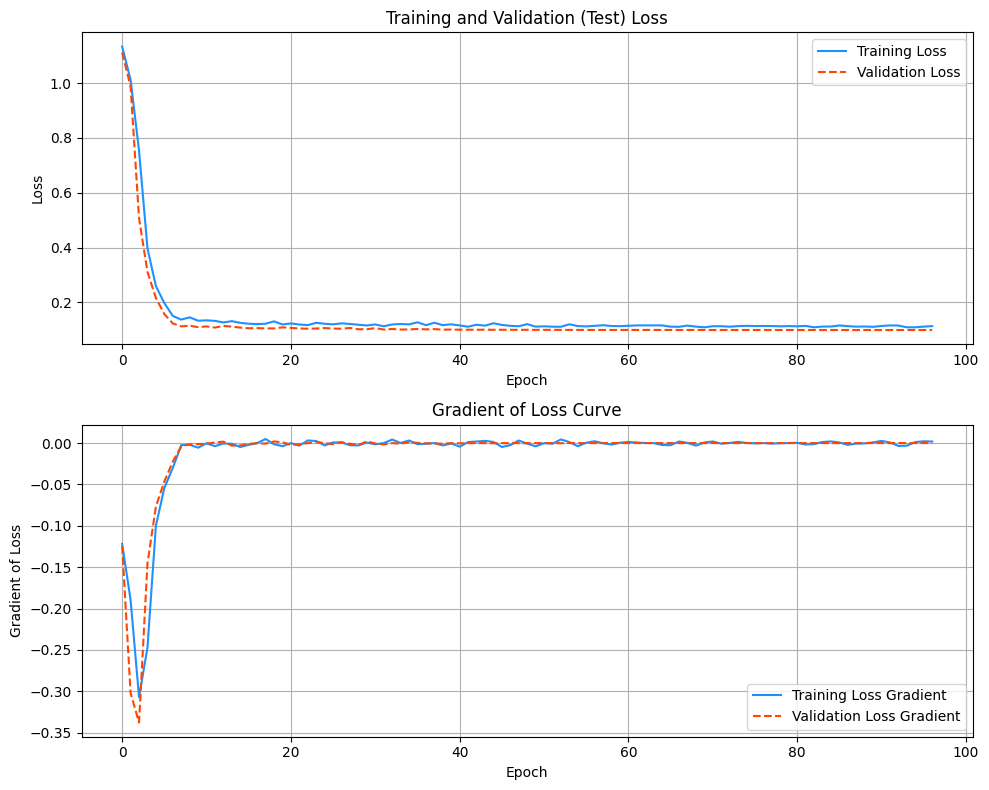

eval_loss_LSTM_Grid: 0.0938374474644661


In [ ]:
##### Train the Model #####

model_LSTM_Grid, loss_history_LSTM_Grid = trainer(
    model_LSTM_Grid, 
    train_dataloader=train_dataloader, 
    x_val_scaled = x_val_scaled, 
    y_val_scaled = y_val_scaled,
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler, 
    max_epochs=200, 
    early_stopping_patience=10,
    )

##### Make a Prediction to the whole Dataset #####

y_pred, eval_loss_LSTM_Grid = predictor(
    model=model_LSTM_Grid, 
    x_test_scaled = x_test_scaled, y_test_scaled = y_test_scaled, 
    criterion=nn.MSELoss(), 
    scaler_y=scaler_y
    )

DateTime = df.index.to_numpy()[lag:]

df['LSTM_Grid'] = np.nan
df.iloc[lag:,  df.columns.get_loc('LSTM_Grid')] = y_pred

model_loss['LSTM_Grid'] = eval_loss_LSTM_Grid.item()
print('eval_loss_LSTM_Grid:', eval_loss_LSTM_Grid.item())


#### Visualize

In [ ]:
# Visualize the result
fig = go.Figure()

# Add the 'Actual' trace
fig.add_trace(go.Scatter(x=df.index, y=df['y'],
                         mode='lines',
                         name='Ground Truth',
                         line=dict(color='black', width=1)))

fig.add_trace(go.Scatter(x=df.index, y=df['y_test'],
                         mode='lines',
                         name='Actual',
                         line=dict(color='blue', width=1)))

# Add the 'Predicted' trace
fig.add_trace(go.Scatter(x=df.index, y=df['LSTM_Bayesian'],
                         mode='lines',
                         name='Predicted (Tuned with BayesSearchCV)',
                         line=dict(color='red', width=1)))

fig.add_trace(go.Scatter(x=df.index, y=df['LSTM_Grid'],
                         mode='lines',
                         name='Predicted (Tuned with GridSearchCV)',
                         line=dict(color='orange', width=1)))

# Update layout for title, axis labels, and grid
fig.update_layout(
    title='Time Series Plot',
    xaxis_title='DateTime',
    yaxis_title='sn_value: total sunspot numbers',
    hovermode='x unified', # This is useful for time series to see values across traces at a given x
    template='plotly_white' # A clean white background template
)

# Add gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()

### Encoder only Transformer

#### Bayesian Optimization

In [ ]:
# Define the Skorch NeuralNetRegressor
# This wraps your PyTorch model to make it scikit-learn compatible

net = NeuralNetRegressor(
    module=TransformerEncoderModel,
    module__input_dim=3,
    module__seq_len=lag,      # Pass the lag as seq_len to the model
    module__output_dim=1,
    module__dropout=0.1,
    max_epochs=200,            # You might want to increase this for better training
    lr=0.01,                  # Initial learning rate, will be optimized
    batch_size=32, 
    optimizer=Adam,
    criterion=nn.MSELoss,
    device=device,
    verbose=0,
    callbacks=[
        ('lr_scheduler', LRScheduler(
            policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
            monitor='valid_loss', # Monitor validation loss to trigger reduction
            factor=0.2,
            patience=3,
        )),
        ('early_stopping', EarlyStopping(
            monitor='valid_loss',    # Monitor validation loss
            patience=10,             # Number of epochs with no improvement before stopping
            threshold=1e-4,          # Minimum change in the monitored metric to qualify as an improvement
            threshold_mode='rel',    # Relative change (can also be 'abs' for absolute change)
            lower_is_better=True,    # Lower validation loss is better
            load_best=True           # Load the best model weights after stopping
        )),
    ]
)

search_spaces = {
    'module__d_model': Categorical([8, 16, 32]),  # Expanded range
    'module__nhead': Categorical([2, 4, 8]),        # Ensure divisibility
    'module__num_layers': Categorical([1, 2, 3]),            # Reduced max layers
    'module__dim_feedforward': Categorical([32, 64, 128]),   # More reasonable range
}

opt = BayesSearchCV(
    estimator=net,
    search_spaces=search_spaces,
    n_iter=50,                          # Number of optimization iterations
    cv=3,                               # 3-fold cross-validation
    scoring='neg_mean_squared_error',   # Optimize for negative MSE (skopt minimizes)
    verbose=2,
    n_jobs=5,                          # Use 10 CPU cores (from 28) for parallelizing folds without making CUDA memory run out.
    random_state=42,
)


In [ ]:
# Run the Bayesian Optimization

x_scaled_cpu = x_train_scaled.cpu().numpy()
y_scaled_cpu = y_train_scaled.cpu().numpy()

print("Starting Bayesian Optimization...")

# Clear CUDA cache before starting hyperparameter search
if torch.cuda.is_available():
    torch.cuda.empty_cache()

opt.fit(x_scaled_cpu, y_scaled_cpu) 

Starting Bayesian Optimization...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=1; total time=   0.9s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=1; total time=   1.0s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=1; total time=   2.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=3; total time=   0.9s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=3; total time=   1.0s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=3; total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=2, module__num_layers

/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [16, 128, 4, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=4, module__num_layers=2; total time=   0.8s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=4, module__num_layers=2; total time=   0.8s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=4, module__num_layers=2; total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   0.6s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   0.9s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   1.4s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [16, 128, 8, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=2; total time=   1.0s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=2; total time=   1.2s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=2; total time=   1.5s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [16, 64, 8, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=3; total time=   1.2s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=3; total time=   1.5s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=3; total time=   4.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=1; total time=   0.6s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=1; total time=   0.9s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=1; total time=   2.3s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [16, 32, 8, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=8, module__num_layers=3; total time=   1.2s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=8, module__num_layers=3; total time=   1.2s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=8, module__num_layers=3; total time=   1.2s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [8, 32, 2, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=3; total time=   0.8s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=3; total time=   1.0s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=3; total time=   2.4s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [32, 64, 4, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   0.5s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   0.7s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   0.7s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [16, 32, 4, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   1.0s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   1.0s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   1.0s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [8, 64, 4, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   1.0s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   1.2s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   1.3s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [32, 32, 4, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=4, module__num_layers=1; total time=   0.5s
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=4, module__num_layers=1; total time=   0.6s
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=4, module__num_layers=1; total time=   0.7s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [16, 128, 8, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=2; total time=   1.0s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=2; total time=   1.2s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=2; total time=   1.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   0.8s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   0.9s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   1.3s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(64), np.int64(8), np.int64(1)] before, using random point [8, 64, 2, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=2, module__num_layers=2; total time=   1.4s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=2, module__num_layers=2; total time=   1.7s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=2, module__num_layers=2; total time=   2.0s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [8, 128, 2, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=2; total time=   1.2s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=2; total time=   1.3s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=2; total time=   1.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=4, module__num_layers=1; total time=   0.7s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=4, module__num_layers=1; total time=   1.7s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=4, module__num_layers=1; total time=   2.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=1; total time=   1.1s
[CV] END module__d

/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(128), np.int64(2), np.int64(1)] before, using random point [16, 32, 4, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   1.0s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   1.0s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   1.1s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(128), np.int64(2), np.int64(1)] before, using random point [32, 128, 4, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=4, module__num_layers=1; total time=   0.6s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=4, module__num_layers=1; total time=   0.6s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=4, module__num_layers=1; total time=   3.5s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [32, 32, 2, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   0.7s
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   0.8s
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   3.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=8, module__num_layers=2; total time=   1.1s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=8, module__num_layers=2; total time=   1.3s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=8, module__num_layers=2; total time=   2.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=4, module__num_layers=2; total time=   0.8s
[CV] END module__d_mod

/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(32), np.int64(8), np.int64(2)] before, using random point [8, 128, 4, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=4, module__num_layers=3; total time=   1.0s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=4, module__num_layers=3; total time=   1.0s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=4, module__num_layers=3; total time=   1.8s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [8, 64, 4, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=2; total time=   0.7s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=2; total time=   0.7s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=2; total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   0.6s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   0.6s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   0.9s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(128), np.int64(8), np.int64(1)] before, using random point [16, 64, 8, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=2; total time=   2.0s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=2; total time=   2.9s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=2; total time=   3.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=2; total time=   0.7s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=2; total time=   1.2s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=2; total time=   2.0s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [16, 64, 2, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=2; total time=   1.0s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=2; total time=   1.7s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=2; total time=   2.5s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [32, 64, 2, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   0.9s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   1.0s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   1.5s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [8, 128, 2, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=2; total time=   1.1s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=2; total time=   1.1s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=2; total time=   2.5s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [32, 64, 2, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   0.6s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   0.9s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   1.2s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [32, 32, 4, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=4, module__num_layers=1; total time=   0.6s
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=4, module__num_layers=1; total time=   0.6s
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=4, module__num_layers=1; total time=   2.0s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [16, 32, 2, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   0.7s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   0.7s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   2.5s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(8), np.int64(64), np.int64(8), np.int64(1)] before, using random point [32, 64, 8, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=8, module__num_layers=1; total time=   0.7s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=8, module__num_layers=1; total time=   0.7s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=8, module__num_layers=1; total time=   0.8s


,estimator,"<class 'skorc...seq_len=120, )"
,search_spaces,"{'module__d_model': Categorical(c...), prior=None), 'module__dim_feedforward': Categorical(c...), prior=None), 'module__nhead': Categorical(c...), prior=None), 'module__num_layers': Categorical(c...), prior=None)}"
,optimizer_kwargs,None
,n_iter,50
,scoring,'neg_mean_squared_error'
,fit_params,None
,n_jobs,10
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [ ]:
# Print the results
print("\n Bayesian Search finished.")
print(f"Best parameters found: {opt.best_params_}")
print(f"Best cross-validation score (negative MSE): {opt.best_score_}")

best_params_model = opt.best_params_

torch.manual_seed(21)

model_TransformerEncoder_Bayesian = TransformerEncoderModel(
    d_model=best_params_model['module__d_model'],
    nhead=best_params_model['module__nhead'],
    num_layers=best_params_model['module__num_layers'],
    dim_feedforward=best_params_model['module__dim_feedforward'],
    input_dim=3,
    output_dim=1,
    seq_len=lag,
    dropout=0.1,
)
optimizer = Adam(model_TransformerEncoder_Bayesian.parameters(), lr=0.0001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0
patience = 10
min_loss = float('inf')

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3)        # To adjust learning rates

print("\n--- Model ---")
print("Model architecture:")
print(model_TransformerEncoder_Bayesian)
print(f"Total parameters: {sum(p.numel() for p in model_TransformerEncoder_Bayesian.parameters() if p.requires_grad)}")



 Bayesian Search finished.
Best parameters found: OrderedDict({'module__d_model': 8, 'module__dim_feedforward': 64, 'module__nhead': 8, 'module__num_layers': 1})
Best cross-validation score (negative MSE): -0.5177965660889944

--- Model ---
Model architecture:
TransformerEncoderModel(
  (input_embedding): Linear(in_features=3, out_features=8, bias=True)
  (position_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=8, bias=True)
        (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((8,), eps=1e-05


--- Training ---
Training started...
Epoch 0 | Train Loss: 1.0937 | Validation (Test) Loss: 1.0337
Epoch 1 | Train Loss: 0.9942 | Validation (Test) Loss: 0.8726
Epoch 2 | Train Loss: 0.8206 | Validation (Test) Loss: 0.7239
Epoch 3 | Train Loss: 0.6999 | Validation (Test) Loss: 0.5942
Epoch 4 | Train Loss: 0.6096 | Validation (Test) Loss: 0.5026
Epoch 5 | Train Loss: 0.5687 | Validation (Test) Loss: 0.4050
Epoch 6 | Train Loss: 0.4753 | Validation (Test) Loss: 0.3412
Epoch 7 | Train Loss: 0.4348 | Validation (Test) Loss: 0.2919
Epoch 8 | Train Loss: 0.3550 | Validation (Test) Loss: 0.2622
Epoch 9 | Train Loss: 0.3383 | Validation (Test) Loss: 0.2373
Epoch 10 | Train Loss: 0.3355 | Validation (Test) Loss: 0.2187
Epoch 11 | Train Loss: 0.3394 | Validation (Test) Loss: 0.2065
Epoch 12 | Train Loss: 0.3243 | Validation (Test) Loss: 0.1977
Epoch 13 | Train Loss: 0.2975 | Validation (Test) Loss: 0.1842
Epoch 14 | Train Loss: 0.2879 | Validation (Test) Loss: 0.1711
Epoch 15 | Train Loss: 0.24

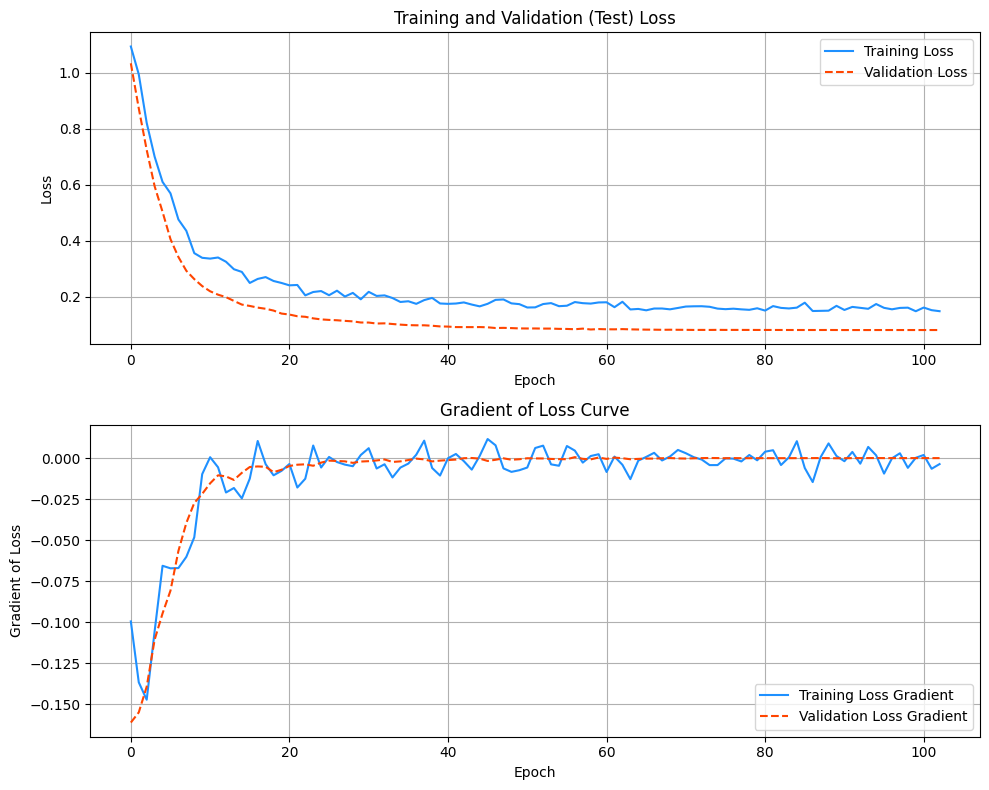

eval_loss_TransformerEncoder_Bayesian: 0.07883694022893906


In [ ]:
##### Train the Model #####

model_TransformerEncoder_Bayesian, loss_history_TransformerEncoder_Bayesian = trainer(
    model_TransformerEncoder_Bayesian, 
    train_dataloader=train_dataloader, 
    x_val_scaled = x_val_scaled, 
    y_val_scaled = y_val_scaled, 
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler, 
    max_epochs=200,
    early_stopping_patience=10,
    )

##### Make a Prediction to the whole Dataset #####

y_pred, eval_loss_TransformerEncoder_Bayesian = predictor(
    model=model_TransformerEncoder_Bayesian, 
    x_test_scaled = x_test_scaled, y_test_scaled = y_test_scaled,
    criterion=nn.MSELoss(), 
    scaler_y=scaler_y
    )

DateTime = df.index.to_numpy()[lag:]

df['TransformerEncoder_Bayesian'] = np.nan
df.iloc[lag:,  df.columns.get_loc('TransformerEncoder_Bayesian')] = y_pred

model_loss['TransformerEncoder_Bayesian'] = eval_loss_TransformerEncoder_Bayesian.item()
print('eval_loss_TransformerEncoder_Bayesian:', eval_loss_TransformerEncoder_Bayesian.item())


#### Grid Search

In [ ]:
# Define the Skorch NeuralNetRegressor
# This wraps your PyTorch model to make it scikit-learn compatible

from skorch.callbacks import EarlyStopping, LRScheduler

# Set random seeds for reproducibility
torch.manual_seed(21)
np.random.seed(21)

net = NeuralNetRegressor(
    module=TransformerEncoderModel,
    module__input_dim=3,
    module__seq_len=lag,      # Pass the lag as seq_len to the model
    module__output_dim=1,
    module__dropout=0.1,
    batch_size = 32,
    max_epochs=200,            # You might want to increase this for better training
    lr=0.0001,               
    optimizer=Adam,
    criterion=nn.MSELoss,
    device=device,
    verbose=0,
    callbacks=[
        ('lr_scheduler', LRScheduler(
            policy=ReduceLROnPlateau,
            monitor='valid_loss', # Monitor validation loss to trigger reduction
            factor=0.2,
            patience=3,
        )),
        ('early_stopping', EarlyStopping(
            monitor='valid_loss',    # Monitor validation loss
            patience=10,             # Number of epochs with no improvement before stopping
            threshold=1e-4,          # Minimum change in the monitored metric to qualify as an improvement
            threshold_mode='rel',    # Relative change (can also be 'abs' for absolute change)
            lower_is_better=True,    # Lower validation loss is better
            load_best=True           # Load the best model weights after stopping
        )),
    ]
)

param_grid = {
    'module__d_model': [8, 16, 32],                          
    'module__nhead': [2, 4, 8],                           # Ensure divisibility (d_model % nhead == 0)
    'module__num_layers': [1, 2, 3],                   # Reduced max layers
    'module__dim_feedforward': [32, 64, 128],        # More reasonable range
}

opt = GridSearchCV(
    estimator=net,
    param_grid=param_grid,
    cv=3,                               # 3-fold cross-validation
    scoring='neg_mean_squared_error',   # Optimize for negative MSE (skopt minimizes)
    verbose=3, 
    n_jobs=5,                         # Use 9 CPU cores (from 29) for parallelizing folds without making CUDA memory run out.
)

# Run the Grid Search

x_scaled_cpu = x_train_scaled.cpu().numpy()
y_scaled_cpu = y_train_scaled.cpu().numpy()

print("Starting Grid Search...")

# Clear CUDA cache before starting hyperparameter search
if torch.cuda.is_available():
    torch.cuda.empty_cache()

opt.fit(x_scaled_cpu, y_scaled_cpu) 

Starting Grid Search...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=2;, score=-1.004 total time=   1.9s
[CV 3/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=3;, score=-0.749 total time=   2.1s
[CV 3/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=1;, score=-0.728 total time=   2.3s
[CV 3/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=2;, score=-0.722 total time=   2.5s
[CV 3/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=4, module__num_layers=1;, score=-0.654 total time=   4.9s
[CV 1/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=4, module__num_layers=1;, score=-0.800 total time=  11.2s
[CV 1/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=1;, score=-0.769 total tim

,estimator,"<class 'skorc...seq_len=120, )"
,param_grid,"{'module__d_model': [8, 16, ...], 'module__dim_feedforward': [32, 64, ...], 'module__nhead': [2, 4, ...], 'module__num_layers': [1, 2, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,10
,refit,True
,cv,3
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,module,<class '__mai...EncoderModel'>


In [ ]:
# Print the results
print("\n Grid Search finished.")
print(f"Best parameters found: {opt.best_params_}")
print(f"Best cross-validation score (negative MSE): {opt.best_score_}")

best_params_model = opt.best_params_

torch.manual_seed(21)
model_TransformerEncoder_Grid = TransformerEncoderModel(
    d_model=best_params_model['module__d_model'],
    dim_feedforward=best_params_model['module__dim_feedforward'],
    nhead=best_params_model['module__nhead'],
    num_layers=best_params_model['module__num_layers'],
    input_dim=3,
    seq_len=lag,
    dropout=0.1,
)
optimizer = Adam(model_TransformerEncoder_Grid.parameters(), lr=0.0001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0
patience = 10
min_loss = float('inf')

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3)        # To adjust learning rates

print("\n--- Model ---")
print("Model architecture:")
print(model_TransformerEncoder_Grid)
print(f"Total parameters: {sum(p.numel() for p in model_TransformerEncoder_Grid.parameters() if p.requires_grad)}")



 Grid Search finished.
Best parameters found: {'module__d_model': 32, 'module__dim_feedforward': 32, 'module__nhead': 4, 'module__num_layers': 2}
Best cross-validation score (negative MSE): -0.3846391836802165

--- Model ---
Model architecture:
TransformerEncoderModel(
  (input_embedding): Linear(in_features=3, out_features=32, bias=True)
  (position_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=32, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, e


--- Training ---
Training started...
Epoch 0 | Train Loss: 0.8254 | Validation (Test) Loss: 0.5079
Epoch 1 | Train Loss: 0.4287 | Validation (Test) Loss: 0.2693
Epoch 2 | Train Loss: 0.2960 | Validation (Test) Loss: 0.1979
Epoch 3 | Train Loss: 0.2453 | Validation (Test) Loss: 0.1520
Epoch 4 | Train Loss: 0.2005 | Validation (Test) Loss: 0.1250
Epoch 5 | Train Loss: 0.1759 | Validation (Test) Loss: 0.1104
Epoch 6 | Train Loss: 0.1645 | Validation (Test) Loss: 0.0996
Epoch 7 | Train Loss: 0.1748 | Validation (Test) Loss: 0.1008
Epoch 8 | Train Loss: 0.1413 | Validation (Test) Loss: 0.1001
Epoch 9 | Train Loss: 0.1442 | Validation (Test) Loss: 0.0897
Epoch 10 | Train Loss: 0.1357 | Validation (Test) Loss: 0.0928
Epoch 11 | Train Loss: 0.1381 | Validation (Test) Loss: 0.0910
Epoch 12 | Train Loss: 0.1407 | Validation (Test) Loss: 0.0884
Epoch 13 | Train Loss: 0.1366 | Validation (Test) Loss: 0.0859
Epoch 14 | Train Loss: 0.1285 | Validation (Test) Loss: 0.0923
Epoch 15 | Train Loss: 0.12

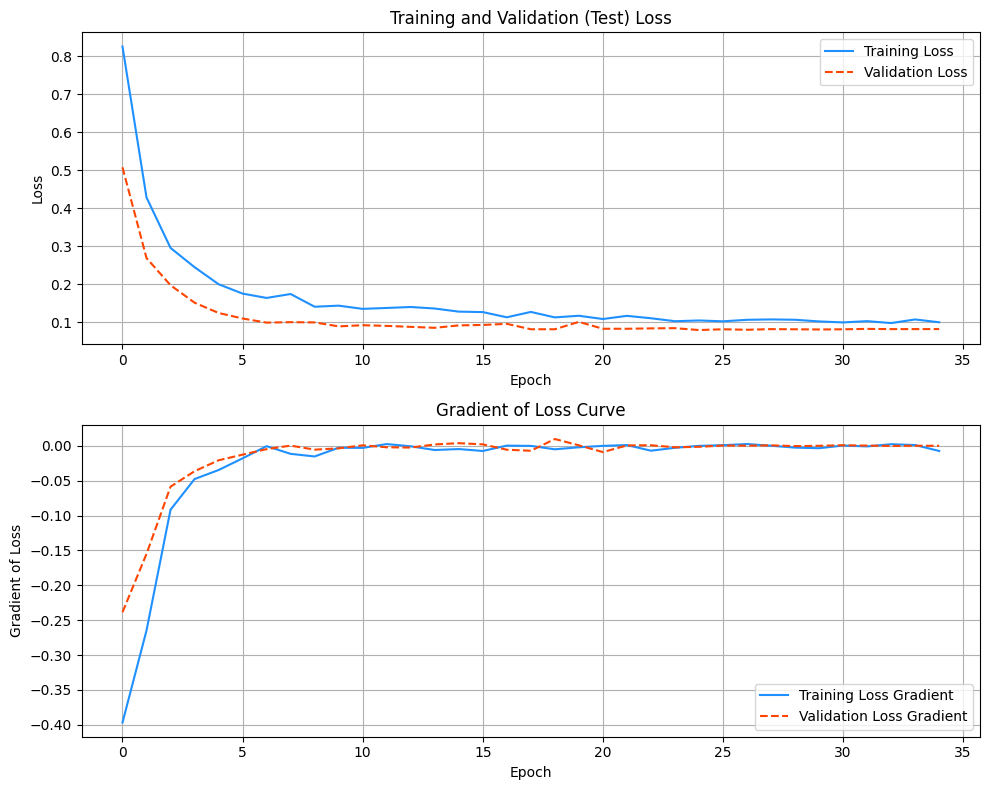

eval_loss_TransformerEncoder_Grid: 0.08100783824920654


In [ ]:
##### Train the Model #####

model_TransformerEncoder_Grid, loss_history_TransformerEncoder_Grid = trainer(
    model_TransformerEncoder_Grid, 
    train_dataloader=train_dataloader, 
    x_val_scaled = x_val_scaled, 
    y_val_scaled = y_val_scaled, 
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler, 
    max_epochs=200,
    early_stopping_patience=10,
    )

##### Make a Prediction to the whole Dataset #####

y_pred, eval_loss_TransformerEncoder_Grid = predictor(
    model=model_TransformerEncoder_Grid, 
    x_test_scaled = x_test_scaled, y_test_scaled = y_test_scaled,
    criterion=nn.MSELoss(), 
    scaler_y=scaler_y
    )

DateTime = df.index.to_numpy()[lag:]

df['TransformerEncoder_Grid'] = np.nan
df.iloc[lag:,  df.columns.get_loc('TransformerEncoder_Grid')] = y_pred

model_loss['TransformerEncoder_Grid'] = eval_loss_TransformerEncoder_Grid.item()
print('eval_loss_TransformerEncoder_Grid:', eval_loss_TransformerEncoder_Grid.item())


#### Visualize

In [ ]:
# Visualize the result
fig = go.Figure()

# Add the 'Actual' trace
fig.add_trace(go.Scatter(x=df.index, y=df['y'],
                         mode='lines',
                         name='Ground Truth',
                         line=dict(color='black', width=1)))

fig.add_trace(go.Scatter(x=df.index, y=df['y_test'],
                         mode='lines',
                         name='Actual',
                         line=dict(color='blue', width=1)))

# Add the 'Predicted' trace
fig.add_trace(go.Scatter(x=df.index, y=df['TransformerEncoder_Bayesian'],
                         mode='lines',
                         name='Predicted (Tuned with BayesSearchCV)',
                         line=dict(color='green', width=1)))

fig.add_trace(go.Scatter(x=df.index, y=df['TransformerEncoder_Grid'],
                         mode='lines',
                         name='Predicted (Tuned with GridSearchCV)',
                         line=dict(color='orange', width=1)))

# Update layout for title, axis labels, and grid
fig.update_layout(
    title='Time Series Plot',
    xaxis_title='DateTime',
    yaxis_title='sn_value: total sunspot numbers',
    hovermode='x unified', # This is useful for time series to see values across traces at a given x
    template='plotly_white' # A clean white background template
)

# Add gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()

### Decoder only Transformer

#### Bayesian Optimization

In [ ]:
# Define the Skorch NeuralNetRegressor
# This wraps your PyTorch model to make it scikit-learn compatible

net = NeuralNetRegressor(
    module=TransformerDecoderModel,
    module__input_dim=3,
    module__seq_len=lag,      # Pass the lag as seq_len to the model
    module__output_dim=1,
    module__dropout=0.1,
    max_epochs=200,            # You might want to increase this for better training
    lr=0.01,                  # Initial learning rate, will be optimized
    batch_size=32, 
    optimizer=Adam,
    criterion=nn.MSELoss,
    device=device,
    verbose=0,
    callbacks=[
        ('lr_scheduler', LRScheduler(
            policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
            monitor='valid_loss', # Monitor validation loss to trigger reduction
            factor=0.2,
            patience=3,
        )),
        ('early_stopping', EarlyStopping(
            monitor='valid_loss',    # Monitor validation loss
            patience=10,             # Number of epochs with no improvement before stopping
            threshold=1e-4,          # Minimum change in the monitored metric to qualify as an improvement
            threshold_mode='rel',    # Relative change (can also be 'abs' for absolute change)
            lower_is_better=True,    # Lower validation loss is better
            load_best=True           # Load the best model weights after stopping
        )),
    ]
)

search_spaces = {
    'module__d_model': Categorical([8, 16, 32]),  # Expanded range
    'module__nhead': Categorical([2, 4, 8]),        # Ensure divisibility
    'module__num_layers': Categorical([1, 2, 3]),            # Reduced max layers
    'module__dim_feedforward': Categorical([32, 64, 128]),   # More reasonable range
}

opt = BayesSearchCV(
    estimator=net,
    search_spaces=search_spaces,
    n_iter=50,                          # Number of optimization iterations
    cv=3,                               # 3-fold cross-validation
    scoring='neg_mean_squared_error',   # Optimize for negative MSE (skopt minimizes)
    verbose=2,
    n_jobs=5,                          # Use 10 CPU cores (from 28) for parallelizing folds without making CUDA memory run out.
    random_state=42,
)


In [ ]:
# Run the Bayesian Optimization

x_scaled_cpu = x_train_scaled.cpu().numpy()
y_scaled_cpu = y_train_scaled.cpu().numpy()

print("Starting Bayesian Optimization...")

# Clear CUDA cache before starting hyperparameter search
if torch.cuda.is_available():
    torch.cuda.empty_cache()

opt.fit(x_scaled_cpu, y_scaled_cpu) 

Starting Bayesian Optimization...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=1; total time=   1.3s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=1; total time=   1.6s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=1; total time=   2.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=3; total time=   1.5s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=3; total time=   1.6s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=3; total time=   1.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=2, module__num_layers

/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [16, 128, 4, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=4, module__num_layers=2; total time=   1.2s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=4, module__num_layers=2; total time=   1.4s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=4, module__num_layers=2; total time=   1.6s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [32, 32, 4, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=4, module__num_layers=1; total time=   0.9s
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=4, module__num_layers=1; total time=   1.0s
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=4, module__num_layers=1; total time=   2.4s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [16, 64, 2, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   0.7s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   1.5s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=2, module__num_layers=1; total time=   1.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=4, module__num_layers=1; total time=   0.8s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=4, module__num_layers=1; total time=   1.0s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=4, module__num_layers=1; total time=   1.6s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [8, 64, 4, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=3; total time=   1.6s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=3; total time=   1.7s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=3; total time=   2.0s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [16, 128, 8, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=3; total time=   2.2s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=3; total time=   2.3s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=3; total time=   2.4s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [16, 32, 2, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   1.8s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   4.5s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   4.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=1; total time=   2.5s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=1; total time=   4.6s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=8, module__num_layers=1; total time=   5.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=3; total time=   1.3s
[CV] END module__d_

/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [32, 128, 8, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=8, module__num_layers=3; total time=   2.5s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=8, module__num_layers=3; total time=   2.6s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=8, module__num_layers=3; total time=   3.4s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [16, 32, 4, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   1.6s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   1.7s
[CV] END module__d_model=16, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   3.1s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [16, 64, 4, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   0.8s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   1.2s
[CV] END module__d_model=16, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   1.7s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [8, 32, 8, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=8, module__num_layers=3; total time=   1.9s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=8, module__num_layers=3; total time=   2.4s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=8, module__num_layers=3; total time=   4.7s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [8, 32, 2, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   1.0s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   1.5s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=2; total time=   1.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   0.8s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   1.4s
[CV] END module__d_model=8, module__dim_feedforward=64, module__nhead=4, module__num_layers=1; total time=   1.4s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(128), np.int64(8), np.int64(1)] before, using random point [8, 128, 8, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=8, module__num_layers=3; total time=   1.9s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=8, module__num_layers=3; total time=   1.9s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=8, module__num_layers=3; total time=   1.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=4, module__num_layers=2; total time=   1.2s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=4, module__num_layers=2; total time=   1.8s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=4, module__num_layers=2; total time=   2.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=2, module__num_layers=1; total time=   0.8s
[CV] END module__d_mo

/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(32), np.int64(2), np.int64(1)] before, using random point [32, 128, 2, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=2; total time=   1.3s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=2; total time=   1.3s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=2; total time=   1.5s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(32), np.int64(2), np.int64(1)] before, using random point [32, 128, 2, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=1; total time=   0.8s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=1; total time=   0.9s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_layers=1; total time=   0.9s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(32), np.int64(2), np.int64(1)] before, using random point [32, 64, 4, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=4, module__num_layers=2; total time=   1.3s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=4, module__num_layers=2; total time=   1.4s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=4, module__num_layers=2; total time=   1.8s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(32), np.int64(2), np.int64(1)] before, using random point [32, 64, 4, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=4, module__num_layers=2; total time=   1.3s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=4, module__num_layers=2; total time=   1.3s
[CV] END module__d_model=32, module__dim_feedforward=64, module__nhead=4, module__num_layers=2; total time=   1.5s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(32), np.int64(2), np.int64(1)] before, using random point [8, 128, 2, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=1; total time=   1.2s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=1; total time=   1.3s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=1; total time=   2.2s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(32), np.int64(2), np.int64(1)] before, using random point [8, 128, 4, 2]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=4, module__num_layers=2; total time=   1.3s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=4, module__num_layers=2; total time=   1.5s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=4, module__num_layers=2; total time=   1.7s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(32), np.int64(2), np.int64(1)] before, using random point [8, 128, 2, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=3; total time=   1.4s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=3; total time=   1.4s
[CV] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_layers=3; total time=   1.4s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(32), np.int64(2), np.int64(1)] before, using random point [16, 128, 8, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=1; total time=   1.0s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=1; total time=   1.3s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_layers=1; total time=   1.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=1; total time=   1.1s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=1; total time=   1.9s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=1; total time=   2.0s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(32), np.int64(2), np.int64(1)] before, using random point [8, 32, 4, 3]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   1.8s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   2.9s
[CV] END module__d_model=8, module__dim_feedforward=32, module__nhead=4, module__num_layers=3; total time=   7.1s


/home/corei7gen14/anaconda3/envs/yotsapat/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(16), np.int64(32), np.int64(2), np.int64(1)] before, using random point [32, 32, 8, 1]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=8, module__num_layers=1; total time=   0.9s
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=8, module__num_layers=1; total time=   1.0s
[CV] END module__d_model=32, module__dim_feedforward=32, module__nhead=8, module__num_layers=1; total time=   1.0s


,estimator,"<class 'skorc...seq_len=120, )"
,search_spaces,"{'module__d_model': Categorical(c...), prior=None), 'module__dim_feedforward': Categorical(c...), prior=None), 'module__nhead': Categorical(c...), prior=None), 'module__num_layers': Categorical(c...), prior=None)}"
,optimizer_kwargs,None
,n_iter,50
,scoring,'neg_mean_squared_error'
,fit_params,None
,n_jobs,10
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [ ]:
# Print the results
print("\n Bayesian Search finished.")
print(f"Best parameters found: {opt.best_params_}")
print(f"Best cross-validation score (negative MSE): {opt.best_score_}")

best_params_model = opt.best_params_

torch.manual_seed(21)

model_TransformerDecoder_Bayesian = TransformerDecoderModel(
    d_model=best_params_model['module__d_model'],
    nhead=best_params_model['module__nhead'],
    num_layers=best_params_model['module__num_layers'],
    dim_feedforward=best_params_model['module__dim_feedforward'],
    input_dim=3,
    output_dim=1,
    seq_len=lag,
    dropout=0.1,
)
optimizer = Adam(model_TransformerDecoder_Bayesian.parameters(), lr=0.0001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0
patience = 10
min_loss = float('inf')

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3)        # To adjust learning rates

print("\n--- Model ---")
print("Model architecture:")
print(model_TransformerDecoder_Bayesian)
print(f"Total parameters: {sum(p.numel() for p in model_TransformerDecoder_Bayesian.parameters() if p.requires_grad)}")



 Bayesian Search finished.
Best parameters found: OrderedDict({'module__d_model': 16, 'module__dim_feedforward': 128, 'module__nhead': 8, 'module__num_layers': 1})
Best cross-validation score (negative MSE): -0.633804589509964

--- Model ---
Model architecture:
TransformerDecoderModel(
  (input_embedding): Linear(in_features=3, out_features=16, bias=True)
  (position_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): L


--- Training ---
Training started...
Epoch 0 | Train Loss: 0.9697 | Validation (Test) Loss: 0.7961
Epoch 1 | Train Loss: 0.6989 | Validation (Test) Loss: 0.5142
Epoch 2 | Train Loss: 0.5207 | Validation (Test) Loss: 0.3463
Epoch 3 | Train Loss: 0.3846 | Validation (Test) Loss: 0.2557
Epoch 4 | Train Loss: 0.3413 | Validation (Test) Loss: 0.2015
Epoch 5 | Train Loss: 0.2734 | Validation (Test) Loss: 0.1638
Epoch 6 | Train Loss: 0.2526 | Validation (Test) Loss: 0.1419
Epoch 7 | Train Loss: 0.2494 | Validation (Test) Loss: 0.1284
Epoch 8 | Train Loss: 0.2169 | Validation (Test) Loss: 0.1291
Epoch 9 | Train Loss: 0.2164 | Validation (Test) Loss: 0.1132
Epoch 10 | Train Loss: 0.1827 | Validation (Test) Loss: 0.1045
Epoch 11 | Train Loss: 0.1937 | Validation (Test) Loss: 0.1018
Epoch 12 | Train Loss: 0.1689 | Validation (Test) Loss: 0.0982
Epoch 13 | Train Loss: 0.1688 | Validation (Test) Loss: 0.0966
Epoch 14 | Train Loss: 0.1640 | Validation (Test) Loss: 0.0940
Epoch 15 | Train Loss: 0.16

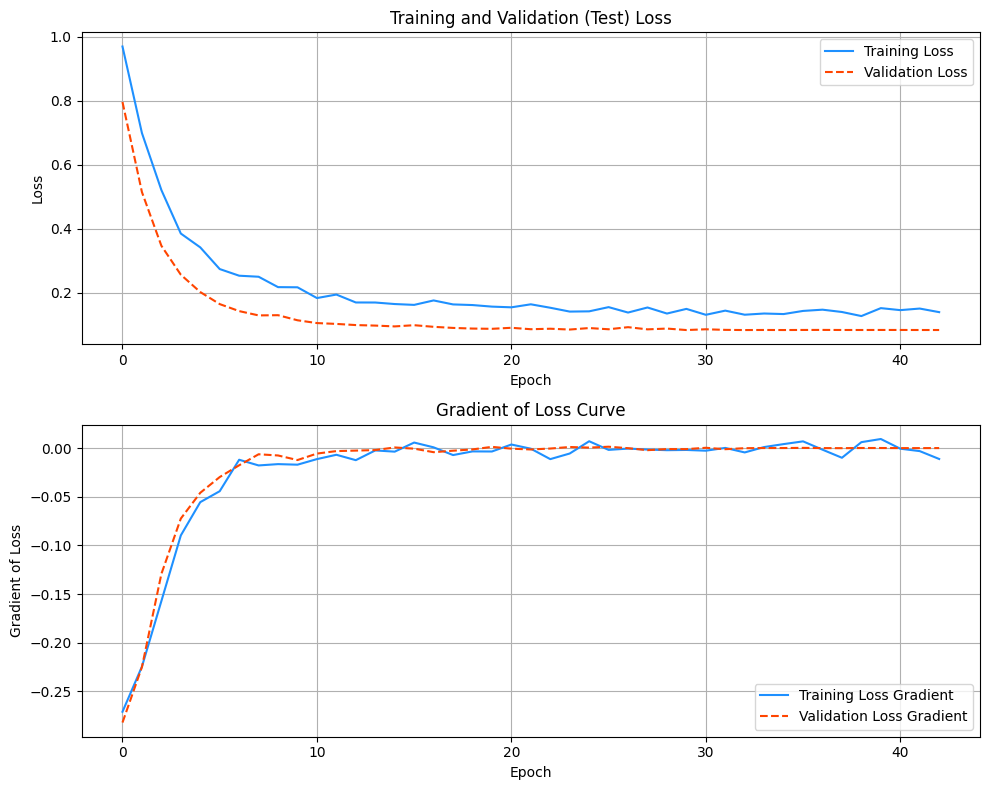

eval_loss_TransformerDecoder_Bayesian: 0.07949984818696976


In [ ]:
##### Train the Model #####

model_TransformerDecoder_Bayesian, loss_history_TransformerDecoder_Bayesian = trainer(
    model_TransformerDecoder_Bayesian, 
    train_dataloader=train_dataloader, 
    x_val_scaled = x_val_scaled, 
    y_val_scaled = y_val_scaled, 
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler, 
    max_epochs=200,
    early_stopping_patience=10,
    )

##### Make a Prediction to the whole Dataset #####

y_pred, eval_loss_TransformerDecoder_Bayesian = predictor(
    model=model_TransformerDecoder_Bayesian, 
    x_test_scaled = x_test_scaled, y_test_scaled = y_test_scaled,
    criterion=nn.MSELoss(), 
    scaler_y=scaler_y
    )

DateTime = df.index.to_numpy()[lag:]

df['TransformerDecoder_Bayesian'] = np.nan
df.iloc[lag:,  df.columns.get_loc('TransformerDecoder_Bayesian')] = y_pred

model_loss['TransformerDecoder_Bayesian'] = eval_loss_TransformerDecoder_Bayesian.item()
print('eval_loss_TransformerDecoder_Bayesian:', eval_loss_TransformerDecoder_Bayesian.item())


#### Grid Search

In [ ]:
# Define the Skorch NeuralNetRegressor
# This wraps your PyTorch model to make it scikit-learn compatible

from skorch.callbacks import EarlyStopping, LRScheduler

# Set random seeds for reproducibility
torch.manual_seed(21)
np.random.seed(21)

net = NeuralNetRegressor(
    module=TransformerDecoderModel,
    module__input_dim=3,
    module__seq_len=lag,      # Pass the lag as seq_len to the model
    module__output_dim=1,
    module__dropout=0.1,
    batch_size = 32,
    max_epochs=200,            # You might want to increase this for better training
    lr=0.0001,               
    optimizer=Adam,
    criterion=nn.MSELoss,
    device=device,
    verbose=0,
    callbacks=[
        ('lr_scheduler', LRScheduler(
            policy=ReduceLROnPlateau,
            monitor='valid_loss', # Monitor validation loss to trigger reduction
            factor=0.2,
            patience=3,
        )),
        ('early_stopping', EarlyStopping(
            monitor='valid_loss',    # Monitor validation loss
            patience=10,             # Number of epochs with no improvement before stopping
            threshold=1e-4,          # Minimum change in the monitored metric to qualify as an improvement
            threshold_mode='rel',    # Relative change (can also be 'abs' for absolute change)
            lower_is_better=True,    # Lower validation loss is better
            load_best=True           # Load the best model weights after stopping
        )),
    ]
)

param_grid = {
    'module__d_model': [8, 16, 32],                          
    'module__nhead': [2, 4, 8],                           # Ensure divisibility (d_model % nhead == 0)
    'module__num_layers': [1, 2, 3],                   # Reduced max layers
    'module__dim_feedforward': [32, 64, 128],        # More reasonable range
}

opt = GridSearchCV(
    estimator=net,
    param_grid=param_grid,
    cv=3,                               # 3-fold cross-validation
    scoring='neg_mean_squared_error',   # Optimize for negative MSE (skopt minimizes)
    verbose=3, 
    n_jobs=5,                         # Use 9 CPU cores (from 29) for parallelizing folds without making CUDA memory run out.
)

# Run the Grid Search

x_scaled_cpu = x_train_scaled.cpu().numpy()
y_scaled_cpu = y_train_scaled.cpu().numpy()

print("Starting Grid Search...")

# Clear CUDA cache before starting hyperparameter search
if torch.cuda.is_available():
    torch.cuda.empty_cache()

opt.fit(x_scaled_cpu, y_scaled_cpu) 

Starting Grid Search...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=1;, score=-1.238 total time=   3.3s
[CV 1/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=3;, score=-1.010 total time=   3.7s
[CV 3/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=2;, score=-0.722 total time=   4.9s
[CV 3/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=3;, score=-0.828 total time=   6.0s
[CV 3/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=4, module__num_layers=1;, score=-0.597 total time=   5.5s
[CV 1/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=4, module__num_layers=2;, score=-1.010 total time=   4.8s
[CV 1/3] END module__d_model=8, module__dim_feedforward=32, module__nhead=2, module__num_layers=2;, score=-0.628 total tim

,estimator,"<class 'skorc...seq_len=120, )"
,param_grid,"{'module__d_model': [8, 16, ...], 'module__dim_feedforward': [32, 64, ...], 'module__nhead': [2, 4, ...], 'module__num_layers': [1, 2, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,10
,refit,True
,cv,3
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,module,<class '__mai...DecoderModel'>


In [ ]:
# Print the results
print("\n Grid Search finished.")
print(f"Best parameters found: {opt.best_params_}")
print(f"Best cross-validation score (negative MSE): {opt.best_score_}")

best_params_model = opt.best_params_

torch.manual_seed(21)
model_TransformerDecoder_Grid = TransformerDecoderModel(
    d_model=best_params_model['module__d_model'],
    dim_feedforward=best_params_model['module__dim_feedforward'],
    nhead=best_params_model['module__nhead'],
    num_layers=best_params_model['module__num_layers'],
    input_dim=3,
    seq_len=lag,
    dropout=0.1,
)
optimizer = Adam(model_TransformerDecoder_Grid.parameters(), lr=0.0001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0
patience = 10
min_loss = float('inf')

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3)        # To adjust learning rates

print("\n--- Model ---")
print("Model architecture:")
print(model_TransformerDecoder_Grid)
print(f"Total parameters: {sum(p.numel() for p in model_TransformerDecoder_Grid.parameters() if p.requires_grad)}")



 Grid Search finished.
Best parameters found: {'module__d_model': 32, 'module__dim_feedforward': 32, 'module__nhead': 2, 'module__num_layers': 2}
Best cross-validation score (negative MSE): -0.3845645785331726

--- Model ---
Model architecture:
TransformerDecoderModel(
  (input_embedding): Linear(in_features=3, out_features=32, bias=True)
  (position_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_fea


--- Training ---
Training started...
Epoch 0 | Train Loss: 0.8162 | Validation (Test) Loss: 0.4532
Epoch 1 | Train Loss: 0.3948 | Validation (Test) Loss: 0.2206
Epoch 2 | Train Loss: 0.2577 | Validation (Test) Loss: 0.1412
Epoch 3 | Train Loss: 0.2075 | Validation (Test) Loss: 0.1177
Epoch 4 | Train Loss: 0.1768 | Validation (Test) Loss: 0.1016
Epoch 5 | Train Loss: 0.1728 | Validation (Test) Loss: 0.1012
Epoch 6 | Train Loss: 0.1655 | Validation (Test) Loss: 0.1062
Epoch 7 | Train Loss: 0.1506 | Validation (Test) Loss: 0.1018
Epoch 8 | Train Loss: 0.1337 | Validation (Test) Loss: 0.0898
Epoch 9 | Train Loss: 0.1417 | Validation (Test) Loss: 0.0913
Epoch 10 | Train Loss: 0.1409 | Validation (Test) Loss: 0.0868
Epoch 11 | Train Loss: 0.1506 | Validation (Test) Loss: 0.0881
Epoch 12 | Train Loss: 0.1284 | Validation (Test) Loss: 0.0814
Epoch 13 | Train Loss: 0.1325 | Validation (Test) Loss: 0.0839
Epoch 14 | Train Loss: 0.1285 | Validation (Test) Loss: 0.0794
Epoch 15 | Train Loss: 0.12

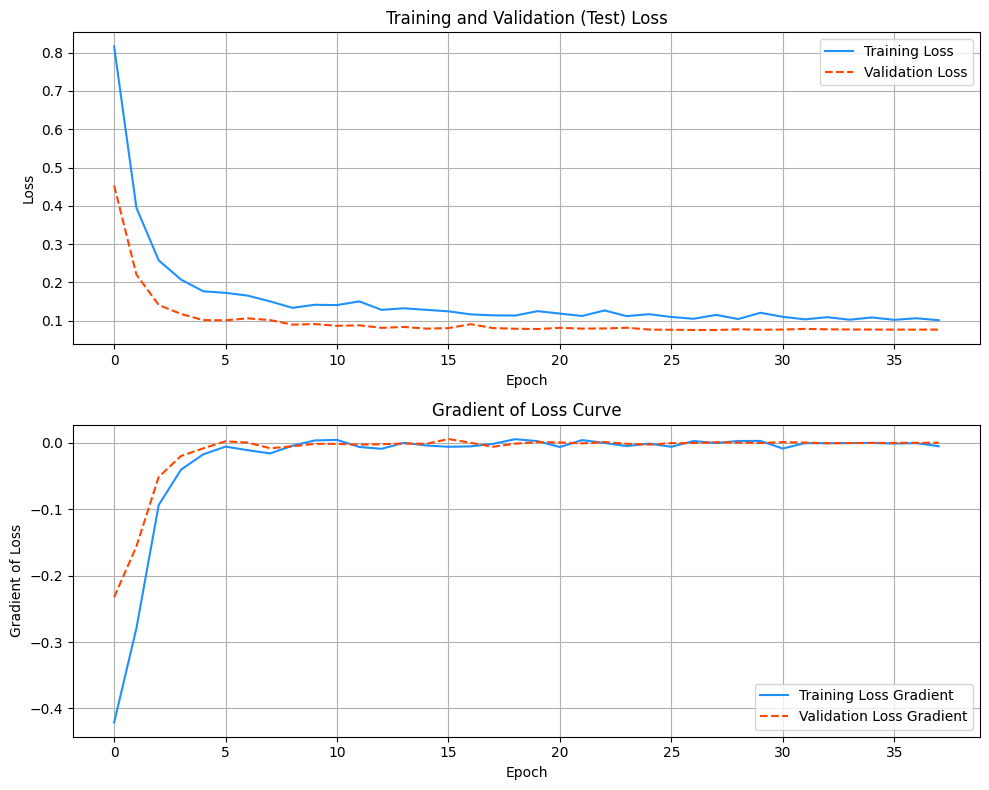

eval_loss_TransformerDecoder_Grid: 0.07615680992603302


In [ ]:
##### Train the Model #####

model_TransformerDecoder_Grid, loss_history_TransformerDecoder_Grid = trainer(
    model_TransformerDecoder_Grid, 
    train_dataloader=train_dataloader, 
    x_val_scaled = x_val_scaled, 
    y_val_scaled = y_val_scaled, 
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler, 
    max_epochs=200,
    early_stopping_patience=10,
    )

##### Make a Prediction to the whole Dataset #####

y_pred, eval_loss_TransformerDecoder_Grid = predictor(
    model=model_TransformerDecoder_Grid, 
    x_test_scaled = x_test_scaled, y_test_scaled = y_test_scaled,
    criterion=nn.MSELoss(), 
    scaler_y=scaler_y
    )

DateTime = df.index.to_numpy()[lag:]

df['TransformerDecoder_Grid'] = np.nan
df.iloc[lag:,  df.columns.get_loc('TransformerDecoder_Grid')] = y_pred

model_loss['TransformerDecoder_Grid'] = eval_loss_TransformerDecoder_Grid.item()
print('eval_loss_TransformerDecoder_Grid:', eval_loss_TransformerDecoder_Grid.item())


#### Visualize

In [ ]:
# Visualize the result
fig = go.Figure()

# Add the 'Actual' trace
fig.add_trace(go.Scatter(x=df.index, y=df['y'],
                         mode='lines',
                         name='Ground Truth',
                         line=dict(color='black', width=1)))

fig.add_trace(go.Scatter(x=df.index, y=df['y_test'],
                         mode='lines',
                         name='Actual',
                         line=dict(color='blue', width=1)))

# Add the 'Predicted' trace
fig.add_trace(go.Scatter(x=df.index, y=df['TransformerDecoder_Bayesian'],
                         mode='lines',
                         name='Predicted (Tuned with BayesSearchCV)',
                         line=dict(color='green', width=1)))

fig.add_trace(go.Scatter(x=df.index, y=df['TransformerDecoder_Grid'],
                         mode='lines',
                         name='Predicted (Tuned with GridSearchCV)',
                         line=dict(color='orange', width=1)))

# Update layout for title, axis labels, and grid
fig.update_layout(
    title='Time Series Plot',
    xaxis_title='DateTime',
    yaxis_title='sn_value: total sunspot numbers',
    hovermode='x unified', # This is useful for time series to see values across traces at a given x
    template='plotly_white' # A clean white background template
)

# Add gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()

### Encoder-Decoder Transformer

Unlike Encoder only and Decoder only, this transformer requires 2 inputs:
1. ``src``: input to be fed into Encoder. ``shape: [batch_size, src_seq_len, input_dim]``
2. ``tqt``: input to be fed into Decoder. ``shape: [batch_size, tqt_seq_len, input_dim]``

``tqt`` can be prepared by simply shift element of ``xb`` in ``src`` by 1 step (the hole lis replaces by 0's)

#### Bayesian Optimization

In [ ]:
# Define the Skorch NeuralNetRegressor
# This wraps your PyTorch model to make it scikit-learn compatible

from skorch.callbacks import EarlyStopping, LRScheduler

net = NeuralNetRegressor(
    module=TransformerEncoderDecoderModel,
    module__input_dim=3,
    module__seq_len=lag,      # Pass the lag as seq_len to the model
    module__output_dim=1,
    module__dropout=0.1,
    batch_size = 32,
    max_epochs=200,            # You might want to increase this for better training
    lr=0.0001,                  # Initial learning rate, will be optimized
    optimizer=Adam,
    criterion=nn.MSELoss,
    device=device,
    verbose=0,
    callbacks=[
        ('lr_scheduler', LRScheduler(
            policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
            monitor='valid_loss', # Monitor validation loss to trigger reduction
            factor=0.2,
            patience=3,
        )),
        ('early_stopping', EarlyStopping(
            monitor='valid_loss',    # Monitor validation loss
            patience=10,             # Number of epochs with no improvement before stopping
            threshold=1e-4,          # Minimum change in the monitored metric to qualify as an improvement
            threshold_mode='rel',    # Relative change (can also be 'abs' for absolute change)
            lower_is_better=True,    # Lower validation loss is better
            load_best=True           # Load the best model weights after stopping
        )),
    ]
)


search_spaces = {
    'module__d_model': Categorical([8, 16, 32]),  # Expanded range
    'module__nhead': Categorical([2, 4, 8]),        # Ensure divisibility
    'module__num_encoder_layers': Categorical([2, 4, 6]), 
    'module__num_decoder_layers': Categorical([2, 4, 6]),   
    'module__dim_feedforward': Categorical([32, 64, 128]),   # More reasonable range
}

opt = BayesSearchCV(
    estimator=net,
    search_spaces=search_spaces,
    n_iter=50,                          # Number of optimization iterations
    cv=3,                               # 3-fold cross-validation
    scoring='neg_mean_squared_error',   # Optimize for negative MSE (skopt minimizes)
    verbose=2,
    n_jobs=5,                          # Use 10 CPU cores (from 28) for parallelizing folds without making CUDA memory run out.
    random_state=42,
)

In [ ]:
# Run the Grid Search

x_scaled_cpu = x_train_scaled.cpu().numpy()
y_scaled_cpu = y_train_scaled.cpu().numpy()

print("Starting Grid Search...")

# Clear CUDA cache before starting hyperparameter search
if torch.cuda.is_available():
    torch.cuda.empty_cache()

opt.fit(x_scaled_cpu, y_scaled_cpu) 

Starting Grid Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_decoder_layers=2, module__num_encoder_layers=6; total time=   2.8s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_decoder_layers=2, module__num_encoder_layers=6; total time=   2.8s
[CV] END module__d_model=16, module__dim_feedforward=128, module__nhead=8, module__num_decoder_layers=2, module__num_encoder_layers=6; total time=   4.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_decoder_layers=6, module__num_encoder_layers=6; total time=   3.1s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_decoder_layers=6, module__num_encoder_layers=6; total time=   3.5s
[CV] END module__d_model=32, module__dim_feedforward=128, module__nhead=2, module__num_d

,estimator,"<class 'skorc...seq_len=120, )"
,search_spaces,"{'module__d_model': Categorical(c...), prior=None), 'module__dim_feedforward': Categorical(c...), prior=None), 'module__nhead': Categorical(c...), prior=None), 'module__num_decoder_layers': Categorical(c...), prior=None), ...}"
,optimizer_kwargs,None
,n_iter,50
,scoring,'neg_mean_squared_error'
,fit_params,None
,n_jobs,10
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [ ]:
# Print the results
print("\n Bayesian Search finished.")
print(f"Best parameters found: {opt.best_params_}")
print(f"Best cross-validation score (negative MSE): {opt.best_score_}")

best_params_model = opt.best_params_

torch.manual_seed(21)

model_TransformerEncoderDecoder_Bayesian = TransformerEncoderDecoderModel(
    d_model=best_params_model['module__d_model'],
    nhead=best_params_model['module__nhead'],
    num_encoder_layers=best_params_model['module__num_encoder_layers'],
    num_decoder_layers=best_params_model['module__num_decoder_layers'],
    dim_feedforward=best_params_model['module__dim_feedforward'],
    input_dim=3,
    output_dim=1,
    seq_len=lag,
    dropout=0.1,
)
optimizer = Adam(model_TransformerEncoderDecoder_Bayesian.parameters(), lr=0.0001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0
patience = 10
min_loss = float('inf')

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3)        # To adjust learning rates

print("\n--- Model ---")
print("Model architecture:")
print(model_TransformerEncoderDecoder_Bayesian)
print(f"Total parameters: {sum(p.numel() for p in model_TransformerEncoderDecoder_Bayesian.parameters() if p.requires_grad)}")



 Bayesian Search finished.
Best parameters found: OrderedDict({'module__d_model': 32, 'module__dim_feedforward': 64, 'module__nhead': 2, 'module__num_decoder_layers': 2, 'module__num_encoder_layers': 2})
Best cross-validation score (negative MSE): -0.709830085436503

--- Model ---
Model architecture:
TransformerEncoderDecoderModel(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.


--- Training ---
Training started...
Epoch 0 | Train Loss: 1.0986 | Validation (Test) Loss: 1.1213
Epoch 1 | Train Loss: 1.1064 | Validation (Test) Loss: 1.0855
Epoch 2 | Train Loss: 1.0529 | Validation (Test) Loss: 1.0196
Epoch 3 | Train Loss: 0.9626 | Validation (Test) Loss: 0.9389
Epoch 4 | Train Loss: 0.8955 | Validation (Test) Loss: 0.8297
Epoch 5 | Train Loss: 0.8110 | Validation (Test) Loss: 0.7296
Epoch 6 | Train Loss: 0.7184 | Validation (Test) Loss: 0.6434
Epoch 7 | Train Loss: 0.6581 | Validation (Test) Loss: 0.5868
Epoch 8 | Train Loss: 0.5878 | Validation (Test) Loss: 0.5773
Epoch 9 | Train Loss: 0.6021 | Validation (Test) Loss: 0.5519
Epoch 10 | Train Loss: 0.5566 | Validation (Test) Loss: 0.5414
Epoch 11 | Train Loss: 0.5532 | Validation (Test) Loss: 0.5313
Epoch 12 | Train Loss: 0.5404 | Validation (Test) Loss: 0.5201
Epoch 13 | Train Loss: 0.5416 | Validation (Test) Loss: 0.5185
Epoch 14 | Train Loss: 0.5182 | Validation (Test) Loss: 0.5167
Epoch 15 | Train Loss: 0.51

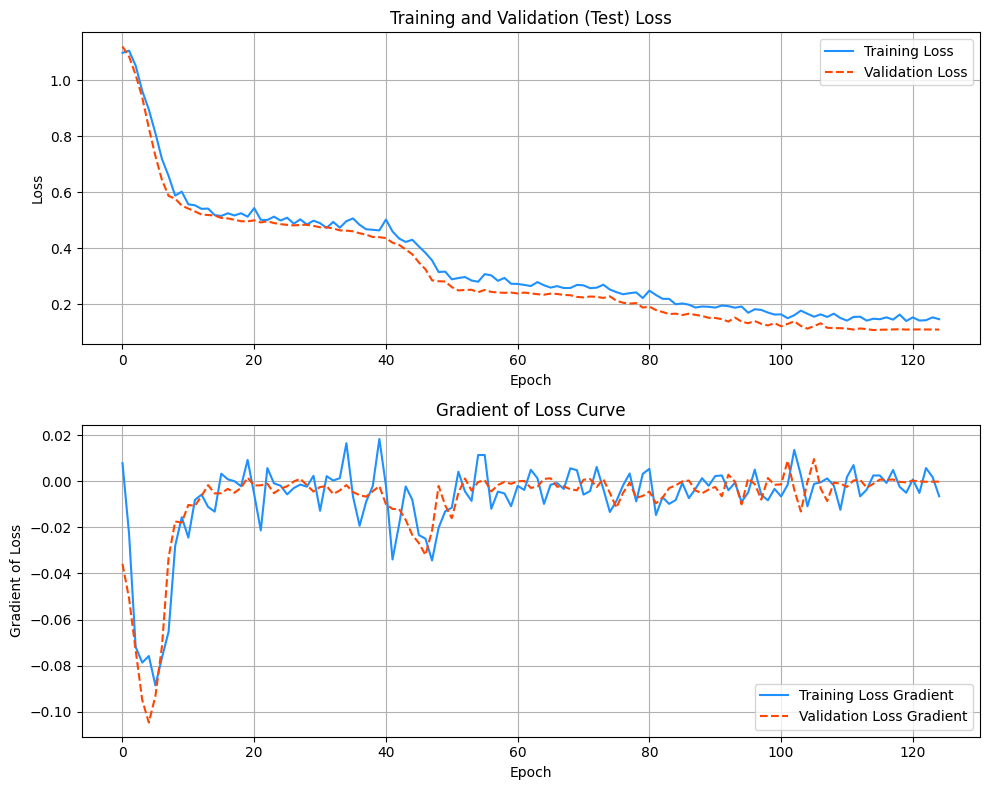

eval_loss_TransformerEncoderDecoder_Bayesian: 0.109288789331913


In [ ]:
##### Train the Model #####

model_TransformerEncoderDecoder_Bayesian, loss_history_TransformerEncoderDecoder_Bayesian = trainer(
    model_TransformerEncoderDecoder_Bayesian, 
    train_dataloader=train_dataloader, 
    x_val_scaled = x_val_scaled, 
    y_val_scaled = y_val_scaled, 
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler, 
    max_epochs=200,
    early_stopping_patience=10,
    )

##### Make a Prediction to the whole Dataset #####

y_pred, eval_loss_TransformerEncoderDecoder_Bayesian = predictor(
    model=model_TransformerEncoderDecoder_Bayesian, 
    x_test_scaled = x_test_scaled, y_test_scaled = y_test_scaled,
    criterion=nn.MSELoss(), 
    scaler_y=scaler_y
    )

DateTime = df.index.to_numpy()[lag:]

df['TransformerEncoderDecoder_Bayesian'] = np.nan
df.iloc[lag:,  df.columns.get_loc('TransformerEncoderDecoder_Bayesian')] = y_pred

model_loss['TransformerEncoderDecoder_Bayesian'] = eval_loss_TransformerEncoderDecoder_Bayesian.item()
print('eval_loss_TransformerEncoderDecoder_Bayesian:', eval_loss_TransformerEncoderDecoder_Bayesian.item())

#### Grid Search

In [ ]:
# Define the Skorch NeuralNetRegressor
# This wraps your PyTorch model to make it scikit-learn compatible

from skorch.callbacks import EarlyStopping, LRScheduler

net = NeuralNetRegressor(
    module=TransformerEncoderDecoderModel,
    module__input_dim=3,
    module__seq_len=lag,      # Pass the lag as seq_len to the model
    module__output_dim=1,
    module__dropout=0.1,
    batch_size = 32,
    max_epochs=200,            # You might want to increase this for better training
    lr=0.0001,                  # Initial learning rate, will be optimized
    optimizer=Adam,
    criterion=nn.MSELoss,
    device=device,
    verbose=0,
    callbacks=[
        ('lr_scheduler', LRScheduler(
            policy=torch.optim.lr_scheduler.ReduceLROnPlateau,
            monitor='valid_loss', # Monitor validation loss to trigger reduction
            factor=0.2,
            patience=3,
        )),
        ('early_stopping', EarlyStopping(
            monitor='valid_loss',    # Monitor validation loss
            patience=10,             # Number of epochs with no improvement before stopping
            threshold=1e-4,          # Minimum change in the monitored metric to qualify as an improvement
            threshold_mode='rel',    # Relative change (can also be 'abs' for absolute change)
            lower_is_better=True,    # Lower validation loss is better
            load_best=True           # Load the best model weights after stopping
        )),
    ]
)

param_grid = {
    'module__d_model': [8, 16, 32],                          # Ensure divisibility (d_model % nhead == 0)
    'module__nhead': [2, 4],                           # Ensure divisibility (d_model % nhead == 0)
    'module__num_encoder_layers': [4, 6], 
    'module__num_decoder_layers': [4, 6],    
    'module__dim_feedforward': [128, 256],        # More reasonable range
}

opt = GridSearchCV(
    estimator=net,
    param_grid=param_grid,
    cv=3,                               # 3-fold cross-validation
    scoring='neg_mean_squared_error',   # Optimize for negative MSE (skopt minimizes)
    verbose=3, 
    n_jobs=5,                         # Use 9 CPU cores (from 29) for parallelizing folds without making CUDA memory run out.
)


In [ ]:
# Run the Grid Search

x_scaled_cpu = x_train_scaled.cpu().numpy()
y_scaled_cpu = y_train_scaled.cpu().numpy()

print("Starting Grid Search...")

# Clear CUDA cache before starting hyperparameter search
if torch.cuda.is_available():
    torch.cuda.empty_cache()

opt.fit(x_scaled_cpu, y_scaled_cpu) 

Starting Grid Search...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 3/3] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_decoder_layers=6, module__num_encoder_layers=4;, score=-0.759 total time=   7.7s
[CV 1/3] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_decoder_layers=4, module__num_encoder_layers=6;, score=-1.009 total time=   8.3s
[CV 1/3] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_decoder_layers=6, module__num_encoder_layers=6;, score=-1.000 total time=   8.4s
[CV 3/3] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_decoder_layers=4, module__num_encoder_layers=4;, score=-0.746 total time=   9.6s
[CV 2/3] END module__d_model=8, module__dim_feedforward=128, module__nhead=2, module__num_decoder_layers=6, module__num_encoder_layers=4;, score=-1.550 total time=  12.9s
[CV 3/3] END module__d_model=8, module__dim_feedforward=128

,estimator,"<class 'skorc...seq_len=120, )"
,param_grid,"{'module__d_model': [8, 16, ...], 'module__dim_feedforward': [128, 256], 'module__nhead': [2, 4], 'module__num_decoder_layers': [4, 6], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,10
,refit,True
,cv,3
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,module,<class '__mai...DecoderModel'>


In [ ]:
# Print the results
print("\n Grid Search finished.")
print(f"Best parameters found: {opt.best_params_}")
print(f"Best cross-validation score (negative MSE): {opt.best_score_}")

best_params_model = opt.best_params_

torch.manual_seed(21)
model_TransformerEncoderDecoder_Grid = TransformerEncoderDecoderModel(
    d_model=best_params_model['module__d_model'],
    num_encoder_layers=best_params_model['module__num_encoder_layers'],
    num_decoder_layers=best_params_model['module__num_decoder_layers'],
    dim_feedforward=best_params_model['module__dim_feedforward'],
    nhead=4,
    input_dim=3,
    seq_len=lag,
    dropout=0.1,
)
model_TransformerEncoderDecoder.to(device)

optimizer = Adam(model_TransformerEncoderDecoder_Grid.parameters(), lr=0.0001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0
patience = 10
min_loss = float('inf')

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3)        # To adjust learning rates

print("\n--- Model ---")
print("Model architecture:")
print(model_TransformerEncoderDecoder_Grid)
print(f"Total parameters: {sum(p.numel() for p in model_TransformerEncoderDecoder_Grid.parameters() if p.requires_grad)}")



 Grid Search finished.
Best parameters found: {'module__d_model': 32, 'module__dim_feedforward': 256, 'module__nhead': 4, 'module__num_decoder_layers': 6, 'module__num_encoder_layers': 4}
Best cross-validation score (negative MSE): -0.5854630966981252

--- Model ---
Model architecture:
TransformerEncoderDecoderModel(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=Fa


--- Training ---
Training started...
Epoch 0 | Train Loss: 1.0784 | Validation (Test) Loss: 1.1111
Epoch 1 | Train Loss: 1.0836 | Validation (Test) Loss: 1.0579
Epoch 2 | Train Loss: 1.0257 | Validation (Test) Loss: 0.9807
Epoch 3 | Train Loss: 0.9404 | Validation (Test) Loss: 0.9210
Epoch 4 | Train Loss: 0.8667 | Validation (Test) Loss: 0.8161
Epoch 5 | Train Loss: 0.8363 | Validation (Test) Loss: 0.7680
Epoch 6 | Train Loss: 0.7418 | Validation (Test) Loss: 0.7539
Epoch 7 | Train Loss: 0.7120 | Validation (Test) Loss: 0.6736
Epoch 8 | Train Loss: 0.6832 | Validation (Test) Loss: 0.6214
Epoch 9 | Train Loss: 0.6145 | Validation (Test) Loss: 0.5760
Epoch 10 | Train Loss: 0.5821 | Validation (Test) Loss: 0.5121
Epoch 11 | Train Loss: 0.5210 | Validation (Test) Loss: 0.4893
Epoch 12 | Train Loss: 0.4583 | Validation (Test) Loss: 0.4319
Epoch 13 | Train Loss: 0.4420 | Validation (Test) Loss: 0.4260
Epoch 14 | Train Loss: 0.4598 | Validation (Test) Loss: 0.4180
Epoch 15 | Train Loss: 0.42

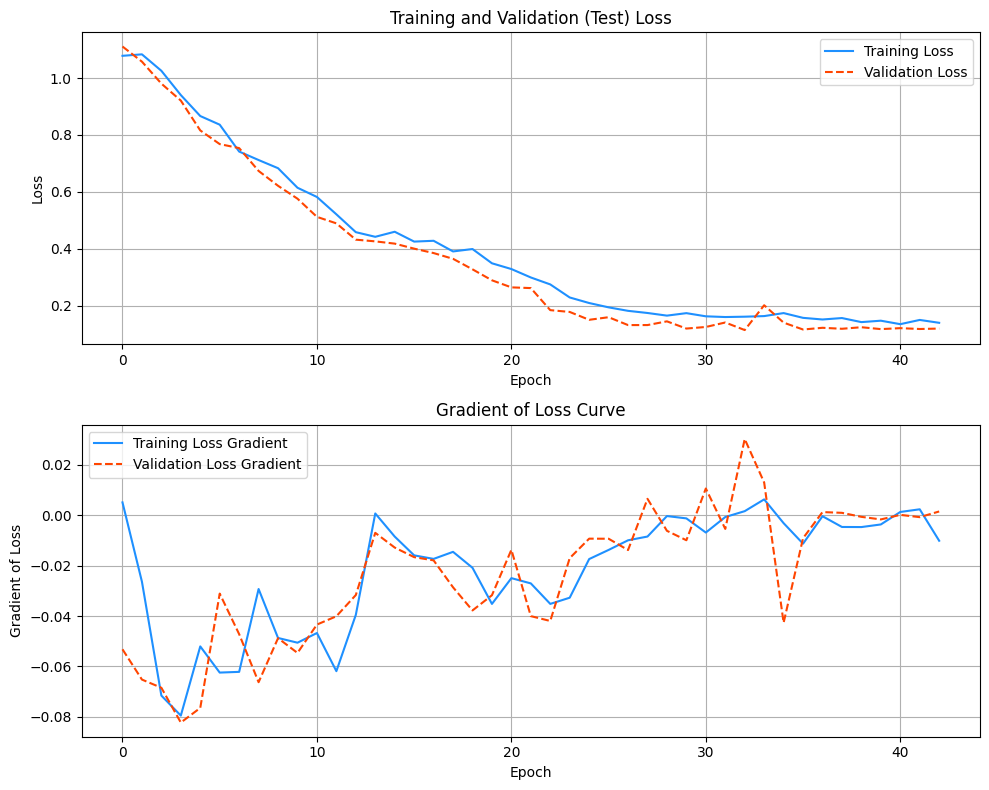

eval_loss_TransformerEncoderDecoder_Grid: 0.1157635822892189


In [ ]:
##### Train the Model #####

model_TransformerEncoderDecoder_Grid, loss_history_TransformerEncoderDecoder_Grid = trainer(
    model_TransformerEncoderDecoder_Grid, 
    train_dataloader=train_dataloader, 
    x_val_scaled = x_val_scaled, 
    y_val_scaled = y_val_scaled, 
    optimizer=optimizer, 
    criterion=criterion, 
    scheduler=scheduler, 
    max_epochs=200, 
    early_stopping_patience=10,
    )

##### Make a Prediction to the whole Dataset #####

y_pred, eval_loss_TransformerEncoderDecoder_Grid = predictor(
    model=model_TransformerEncoderDecoder_Grid, 
    x_test_scaled = x_test_scaled, y_test_scaled = y_test_scaled, 
    criterion=nn.MSELoss(), 
    scaler_y=scaler_y
    )

DateTime = df.index.to_numpy()[lag:]

df['TransformerEncoderDecoder_Grid'] = np.nan
df.iloc[lag:,  df.columns.get_loc('TransformerEncoderDecoder_Grid')] = y_pred

model_loss['TransformerEncoderDecoder_Grid'] = eval_loss_TransformerEncoderDecoder_Grid.item()
print('eval_loss_TransformerEncoderDecoder_Grid:', eval_loss_TransformerEncoderDecoder_Grid.item())


#### Visualize

In [ ]:
# Visualize the result
fig = go.Figure()

# Add the 'Actual' trace
fig.add_trace(go.Scatter(x=df.index, y=df['y'],
                         mode='lines',
                         name='Ground Truth',
                         line=dict(color='black', width=1)))

fig.add_trace(go.Scatter(x=df.index, y=df['y_test'],
                         mode='lines',
                         name='Actual',
                         line=dict(color='blue', width=1)))

# Add the 'Predicted' trace
fig.add_trace(go.Scatter(x=df.index, y=df['TransformerEncoderDecoder_Bayesian'],
                         mode='lines',
                         name='Predicted (Tuned with BayesSearchCV)',
                         line=dict(color='green', width=1)))

fig.add_trace(go.Scatter(x=df.index, y=df['TransformerEncoderDecoder_Grid'],
                         mode='lines',
                         name='Predicted (Tuned with GridSearchCV)',
                         line=dict(color='orange', width=1)))

# Update layout for title, axis labels, and grid
fig.update_layout(
    title='Time Series Plot',
    xaxis_title='DateTime',
    yaxis_title='sn_value: total sunspot numbers',
    hovermode='x unified', # This is useful for time series to see values across traces at a given x
    template='plotly_white' # A clean white background template
)

# Add gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()

## Visualize all results

In [ ]:
df

,x_1,x_2,y,y_train,y_val,y_test,x_1_scaled,x_2_scaled,y_scaled,y_train_scaled,...,LSTM_Grid,TransformerEncoder,TransformerEncoder_Bayesian,TransformerEncoder_Grid,TransformerDecoder,TransformerDecoder_Bayesian,TransformerDecoder_Grid,TransformerEncoderDecoder,TransformerEncoderDecoder_Bayesian,TransformerEncoderDecoder_Grid
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-09-01,18.880598,23.851421,36.104874,36.199993,35.442173,36.146908,-0.408282,-1.277582,0.744712,0.769855,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-02,20.932270,23.728292,35.910999,37.295555,37.140640,37.790283,-0.324214,-1.291651,0.693463,1.059453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-03,22.970074,23.045330,35.374214,36.578751,35.002853,37.062405,-0.240714,-1.369687,0.551571,0.869975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-04,24.971857,23.046120,34.913071,35.304630,35.950985,34.379868,-0.158691,-1.369597,0.429673,0.533177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-05,26.916069,22.216122,34.670696,35.093040,34.390961,36.427433,-0.079026,-1.464433,0.365605,0.477246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-10,66.416466,31.637501,37.064270,37.798542,37.670071,35.267467,1.539514,-0.387935,0.998316,1.192412,...,36.703850,36.996027,36.950746,37.531365,37.161589,37.621274,37.308112,35.494764,37.102663,37.020539
2025-04-11,67.587997,32.351738,37.156784,36.798973,37.679394,37.553612,1.587518,-0.306325,1.022771,0.928188,...,36.489327,37.016807,36.998442,37.580203,37.100451,37.645035,37.296512,35.495910,37.153956,37.027758
2025-04-12,68.654289,33.159348,37.234612,37.415295,37.749844,35.905327,1.631210,-0.214047,1.043344,1.091105,...,36.593597,37.187860,37.174141,37.709322,37.160117,37.731898,37.450175,35.497039,37.212979,37.058027


In [ ]:
model_loss

{'LSTM': 0.10152267664670944,
 'LSTM_Bayesian': 0.09490194916725159,
 'LSTM_Grid': 0.0938374474644661,
 'TransformerEncoder': 0.0770411491394043,
 'TransformerEncoder_Bayesian': 0.07883694022893906,
 'TransformerEncoder_Grid': 0.08100783824920654,
 'TransformerDecoder': 0.08648327738046646,
 'TransformerDecoder_Bayesian': 0.07949984818696976,
 'TransformerDecoder_Grid': 0.07615680992603302,
 'TransformerEncoderDecoder': 0.5142241716384888,
 'TransformerEncoderDecoder_Bayesian': 0.109288789331913,
 'TransformerEncoderDecoder_Grid': 0.1157635822892189}

In [ ]:
# Visualize the result
fig = go.Figure()

# Plot the actual test dataset
fig.add_trace(go.Scatter(x=df.index, y=df['y'],
                         mode='lines',
                         name='Ground Truth',
                         line=dict(color='black', width=1)))

fig.add_trace(go.Scatter(x=df.index, y=df['y_test'],
                         mode='lines',
                         name='Actual',
                         line=dict(color='blue', width=1)))

# Plot predictions

cols_model = ['LSTM', 'TransformerEncoder', 'TransformerDecoder', 'TransformerEncoderDecoder']
cols_tune = ['Bayesian', 'Grid']

for col_model in cols_model:
    for col_tune in cols_tune:
        col = f'{col_model}_{col_tune}'
        name = f'Predicted {col_model} ({col_tune})'
        fig.add_trace(go.Scatter(x=df.index, y=df[col],
                                mode='lines',
                                name=name,                                 
                                line=dict(width=1)))

# Update layout for title, axis labels, and grid
fig.update_layout(
    title='Time Series Plot',
    xaxis_title='DateTime',
    yaxis_title='sn_value: total sunspot numbers',
    hovermode='x unified', # This is useful for time series to see values across traces at a given x
    template='plotly_white' # A clean white background template
)

# Add gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()